In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import torch

DATASETS = '../datasets/'

def read_file(dir_name):
    main_df = pd.DataFrame()
    directory = DATASETS + dir_name
    for filename in os.listdir(directory):
        data = np.load(os.path.join(directory, filename))
        data_dict = {}
        for keys in data.keys():
            data_dict[keys] = list(data[keys])
        df = pd.DataFrame.from_dict(data_dict)
        main_df = pd.concat([main_df, df])
    return main_df

In [2]:
data = []
for name in os.listdir("../datasets/mw"):
    inner_df = pd.DataFrame()
    if not (name.startswith('.')):
        dir_name = 'mw/'+name
        print(dir_name)
        df = read_file(dir_name)
        inner_df = pd.concat([inner_df, df])    
    data.append(inner_df)
data = np.array(data, dtype=object)


mw/cls_sweep-v2
mw/cls_push-v2
mw/cls_door-open-v2
mw/cls_peg-insert-side-v2
mw/cls_drawer-close-v2
mw/cls_basketball-v2
mw/cls_reach-v2
mw/cls_window-open-v2
mw/cls_pick-place-v2
mw/cls_button_press_topdown-v2


# MAIN CODE

In [10]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import warnings
import copy
import matplotlib.pyplot as plt
import random
import math
from torch.nn import functional as F
warnings.filterwarnings('ignore')


class MetaRewardMLPEnsemble(nn.Module):
    def __init__(
        self,
        hidden_layers=[256, 256, 256],
        # ensemble_size=3,
        act=F.leaky_relu,
        output_act=torch.tanh,
    ):
        super().__init__()
        params = {}
        last_dim = 39 + 4
        self.num_layers = len(hidden_layers) + 1
        for i, dim in enumerate(
            hidden_layers
            + [
                1,
            ]
        ):
            weight = torch.empty(last_dim, dim)
            weight.transpose_(0, 1)
            nn.init.kaiming_uniform_(weight, a=math.sqrt(5))
            weight.transpose_(0, 1)
            params[f"linear_w_{i}"] = nn.Parameter(weight)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(params[f"linear_w_{i}"].T)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            params[f"linear_b_{i}"] = nn.Parameter(
                nn.init.uniform_(torch.empty(1, dim, requires_grad=True), -bound, bound)
            )
            last_dim = dim

        self.params = nn.ParameterDict(params)
        self.parameters = self.params.parameters ######### NEW
        # self.ensemble_size = ensemble_size
        self.act = act
        self.output_act = output_act

    def forward(self, x, params=None):
        if params is None:
            params = self.params
        # x = torch.cat((obs, action), dim=1)
        # x = x.repeat(self.ensemble_size, 1, 1)
        for i in range(self.num_layers):
            x = params[f"linear_b_{i}"] + torch.matmul( x, params[f"linear_w_{i}"] )
            if i == self.num_layers - 1:
                x = self.output_act(x)
            else:
                x = self.act(x)
        return x.squeeze(-1)

class PreferenceMAML:
    def __init__(
        self,
        ml10,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        outer_lr = 1e-7,
        inner_lr = 0.001,
        num_support=10,
        num_query=10,
        num_inner_steps=5,
        k = 25,
        num_tasks = 10,
        episode_per_task = 1250,
        output_size = 2750,
        beta1 = 0.9, 
        beta2 = 0.999,
        adam_alpha = 0.001,
        adam_eps = 1e-8,
        **kwargs,
    ):
        self.ml10 = ml10
        self.reward_criterion =  nn.BCELoss()
        self.num_support = num_support
        self.num_query = num_query
        self.num_inner_steps = num_inner_steps
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.k = k
        self.num_tasks = num_tasks
        self.episode_per_task = episode_per_task
        self.num_segments = None
        self.model = MetaRewardMLPEnsemble()
        self.beta1 = beta1
        self.beta2 = beta2
        self.adam_alpha = adam_alpha
        self.adam_eps = adam_eps
        self.m_dict = {k: torch.zeros_like(v) for k, v in self.model.params.items()}
        self.v_dict = {k: torch.zeros_like(v) for k, v in self.model.params.items()}
        self._lrs = torch.nn.ParameterDict(
            {
                k: torch.nn.Parameter(torch.tensor(self.inner_lr), requires_grad=True)
                for k, v in self.model.params.items()
            }
        )
        self.optim = optim.Adam(itertools.chain(self.model.params.values(), self._lrs.values()), lr=0.0001)


    def construct_episodes(self, ml10):
        # episodes - n (tasks) x num_episode (each npz file)  , each cell is a dataframe of the episode 
        self.episodes = []
        for task in ml10:
            if(len(task)==0):
                continue
            task_episodes=[]
            row_index = task[task['done'] == True].index.tolist()
            prev=0
            for x in row_index:
                task_episodes.append(task[prev:x+1])
                prev=x+1
            task_episodes = np.array(task_episodes,dtype=object)
            self.episodes.append(task_episodes)
        self.episodes = np.array(self.episodes,dtype=object)
        # return episodes

    def form_sigma_groups(self, episode):
        #num_segments = int(episode.shape[0] / self.k)
        split_indices = np.arange(self.k, episode.shape[0], self.k)
        # print(num_segments)
        if len(split_indices) != 0:
            l_segment = np.array_split(episode.iloc[::-1][:(self.k*(episode.shape[0] // self.k))], split_indices)
            for i in range(len(l_segment)):
                l_segment[i] = l_segment[i].iloc[::-1]
            if(len(l_segment[-1])<25):
                l_segment=l_segment[:-1]
            return l_segment
        else:
            return None

    def compare_probabilities(self, sigma1, sigma2):
        exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
        exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
        prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
        return [0] if prob > 0.5 else [1]

    def prepare_data(self):
        X = []
        y = []
        episodes = self.episodes
        # sigmas = self.form_sigma_groups(episodes, k)
        sigmas = []
        for task in episodes:
            sigma = []
            for episode in task:
                segment = self.form_sigma_groups(episode)
                # print(len(segment))
                if segment is not None:
                    sigma.append(segment)
            # sigma = [self.form_sigma_groups(episode, k) for episode in task]
            sigmas.append(sigma)
        sigmas = np.array(sigmas, dtype=object)
        all_lengths = [len(episode) for task in sigmas for episode in task]
        self.num_segments = min(all_lengths)
        if(self.num_segments<3):
            self.num_segments=3
        for task in sigmas:
            task_list=[]
            for episode in task:
                ep_list=[]
                if(len(episode)<self.num_segments):
                    continue
                for i in range(self.num_segments):
                    y.append(episode[i]["reward"])
                    ep_list.append(episode[i].drop('reward', axis=1))
                task_list.append(ep_list)
            task_list=np.array(task_list, dtype=object).reshape(-1,1) # convert row vector to col vector
            X.append(task_list)
        X_new=[]
        task_counter = []
        for task in X:
            counter = 0
            for i in range(0,len(task),4):
                X_new.append(np.concatenate((task[i][0], task[i+1][0])))
                counter += 1
            task_counter.append(counter)
        X = np.array(X_new, dtype=object)
        task_counts = np.array(task_counter, dtype=object)
        y=np.array(y,dtype=object)
        y=y.flatten()
        return X, y, task_counts
    
    def batchify(self, X, y, task_lengths, task_no, num=110):
        # print(task_no)
        if task_no == 0:
            task_beg = 0  
            task_end = task_lengths[0]
        else:    
            task_beg = np.sum(task_lengths[0:task_no])    
            task_end = np.sum(task_lengths[0:task_no+1])
        rand = random.sample(range(0,400), 110)
        X_task = X[task_beg:task_end]
        y_task = y[task_beg:task_end]
        X_random = []
        y_random = []
        for r in rand:
            X_random.append(X_task[r*25 : r*25+25])
            y_random.append(y_task[r*25 : r*25+25])
        X_random = np.array(X_random, dtype=np.float32)
        y_random = np.array(y_random, dtype=np.float32)
        return X_random.reshape(2750,43), y_random.reshape(2750,)


    def train(self, X, y, task_lengths, num_epochs):
        plt_x = np.arange(0, num_epochs)
        plt_y = np.zeros(num_epochs)
        for epoch in tqdm(range(num_epochs)):
            self.optim.zero_grad()
            loss = self._outer_step(self.model, X, y, task_lengths) 
            if loss is None:
                return {}
            # print('loss from train:', loss)
            plt_y[epoch] = loss
            
            idx = 0
            if epoch % 25 == 0:
                plt.plot(plt_x[:epoch+1], plt_y[:epoch+1])
                plt.xlabel("Epochs")
                plt.ylabel("Mean Loss")
                plt.show() 
                print(f"Epoch: {epoch}, Loss: {plt_y[epoch]}")
            loss.backward()
            self.optim.step()


    def _outer_step(self, model, X, y, task_lengths):
        outer_losses = []
        for t in range(self.num_tasks):
            X_b, y_b = self.batchify(X, y, task_lengths, t)
            H, W = X_b.shape
            inner_x = X_b[:H//2, :]
            inner_y = y_b[:H//2]
            outer_x = X_b[H//2:, :]
            outer_y = y_b[H//2:]
            weights = self._inner_loop(inner_x, inner_y, model = model)
            outer_losses.append(self._compute_loss(outer_x, outer_y, model, parameters=weights))
        # print(outer_losses)
        if (len(outer_losses) == 0):
            return None
        outer_loss = torch.mean(torch.stack(outer_losses))
        # print("Outer Loss: ", loss)
        return outer_loss


            
    def _inner_loop(self, X, y, model):
        params_og = model.params
        new_dict = {k: torch.clone(v) for k, v in params_og.items()} ######### state_dict                                                     ######### IN 2nd EPOCH SOMEHOW new_dict has values {new_dict from 1st epoch +/- 256}


        loss = self._compute_loss(X, y, model, parameters = new_dict)
        grad = torch.autograd.grad(loss, new_dict.values(), create_graph=True)

        idx = 0
        for name, w in params_og.items():
            if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
                new_dict[name] = new_dict[name] - 0.001 * grad[idx]
            else:
                new_dict[name] = new_dict[name] - 0.001 * grad[idx]
            idx += 1
        return new_dict

    '''
    R_E = 
    [
        [
            sigma_s1^E1, ..., sigma_s#^E1
        ],
        [
            sigma_s1^E2, ..., sigma_s#^E2
        ], ...,
        [
            sigma_s1^EN, ..., sigma_s#^EN
        ]
    ]
    '''
    #self.k = segment lenght
    def _compute_loss(self, X, y, model, parameters = None):
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        if parameters is not None:
            output_reward = model.forward(X_tensor, parameters) # WORKING
        else:
            print('Params are NONE')
            output_reward = model(X_tensor)
        # N_o, _ = output_reward.shape
        # print(output_reward.shape)
        x =  y_tensor.shape[0]
        N = x//self.k
        output_reward = output_reward.reshape(N, self.k)
        output_reward = torch.sum(output_reward, dim=1)
        y_tensor = y_tensor.reshape(N, self.k)
        y_tensor = torch.sum(y_tensor, dim=1)
        loss = 0
        criterion = nn.BCEWithLogitsLoss()
        loss = []
        for i in range(N):
            for j in range(i+1, N):
                if y_tensor[i] > y_tensor[j]:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(0.0, requires_grad= True)))
                else:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(1.0, requires_grad= True)))

        loss = torch.mean(torch.stack(loss)) #### sum

        return loss

################################################################################################
################################################################################################
################################################################################################

ml10 = data.copy()  
input_size = 43  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
# hidden_size3 = 1024
# hidden_size4 = 2075

output_size = 1
num_epochs = 5
outer_lr = 0.0001

model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, hidden_size3)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

model.construct_episodes(ml10)
print('Preparing Data.')



Preparing Data.


In [6]:
X, y, task_lengths = model.prepare_data()
print('Data Preparation Done.\n')

Data Preparation Done.



  0%|          | 0/5000 [00:00<?, ?it/s]

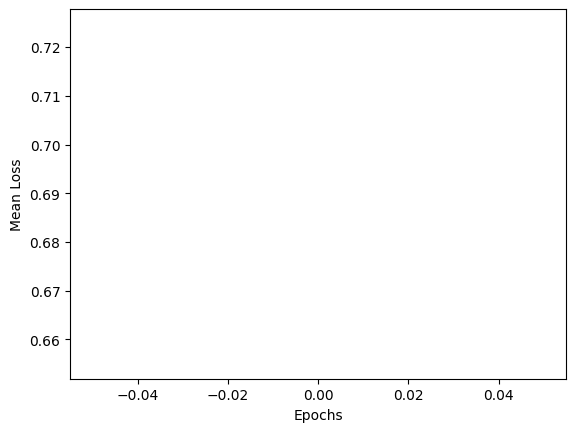

Epoch: 0, Loss: 0.6898577809333801


  0%|          | 25/5000 [00:58<3:14:30,  2.35s/it]

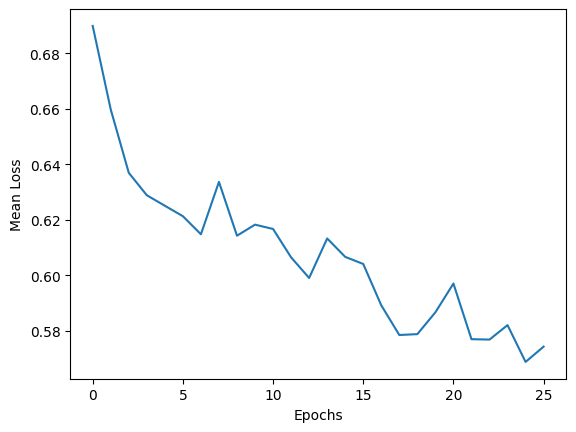

Epoch: 25, Loss: 0.5743386149406433


  1%|          | 50/5000 [01:59<3:18:31,  2.41s/it]

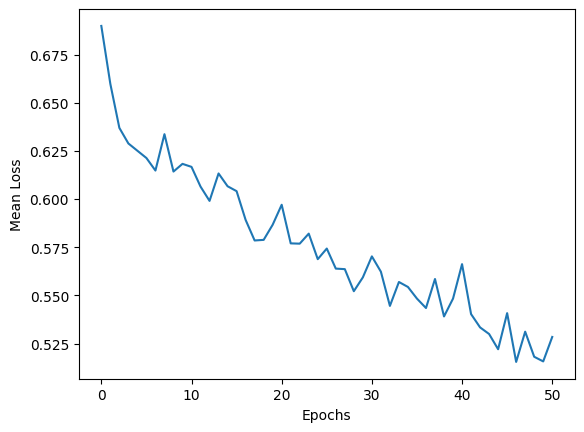

Epoch: 50, Loss: 0.5284721255302429


  2%|▏         | 75/5000 [02:57<3:17:45,  2.41s/it]

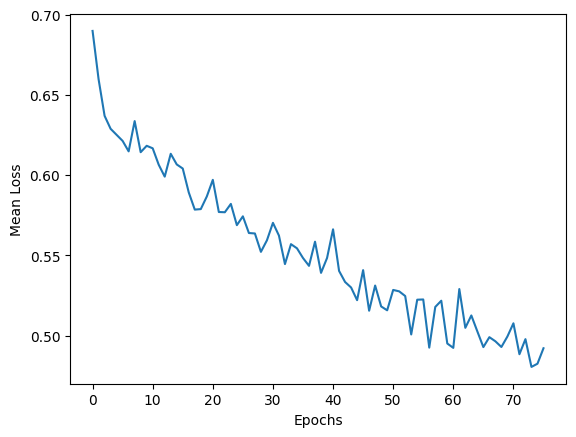

Epoch: 75, Loss: 0.49214115738868713


  2%|▏         | 100/5000 [03:58<3:10:17,  2.33s/it]

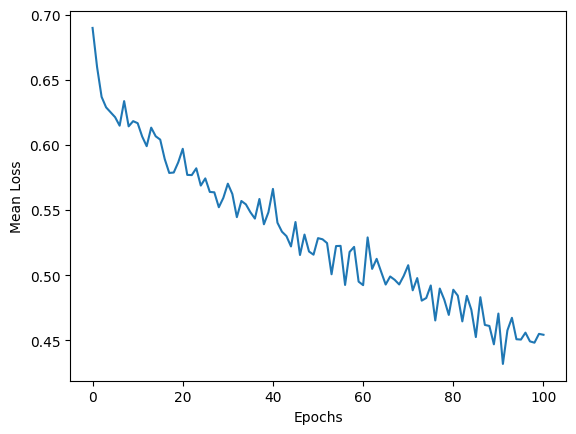

Epoch: 100, Loss: 0.45427829027175903


  2%|▎         | 125/5000 [04:58<3:08:21,  2.32s/it]

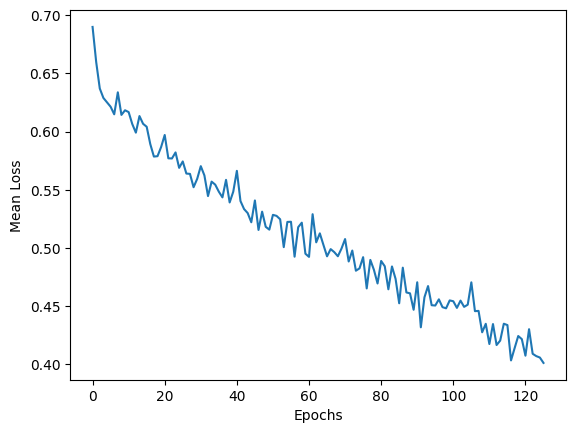

Epoch: 125, Loss: 0.4013097882270813


  3%|▎         | 150/5000 [05:57<3:05:30,  2.29s/it]

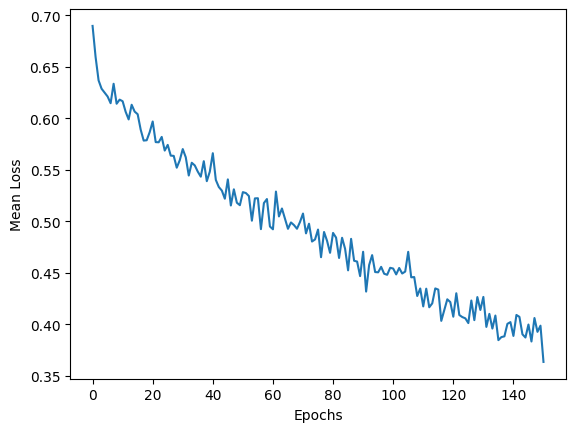

Epoch: 150, Loss: 0.3636036813259125


  4%|▎         | 175/5000 [06:55<3:19:04,  2.48s/it]

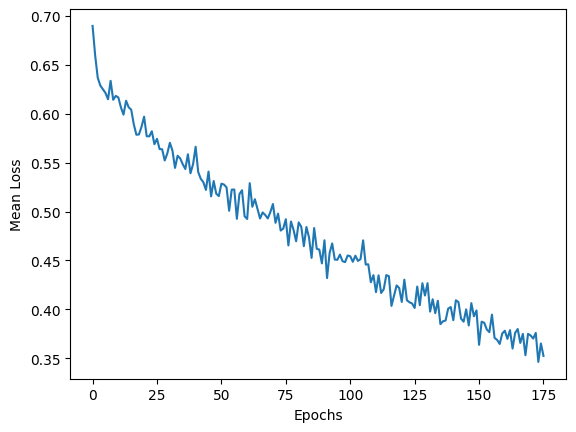

Epoch: 175, Loss: 0.3522765338420868


  4%|▍         | 200/5000 [07:55<3:09:15,  2.37s/it]

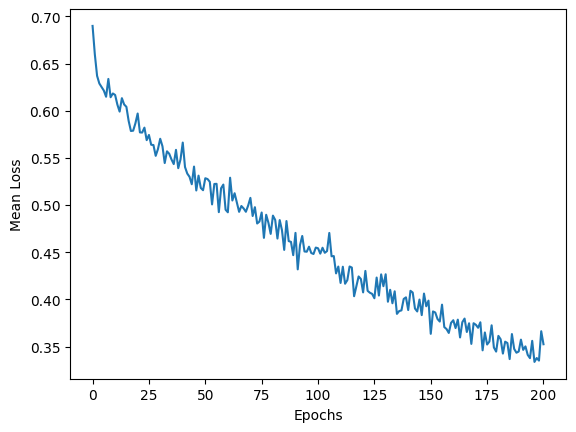

Epoch: 200, Loss: 0.3525746762752533


  4%|▍         | 225/5000 [08:56<3:23:08,  2.55s/it]

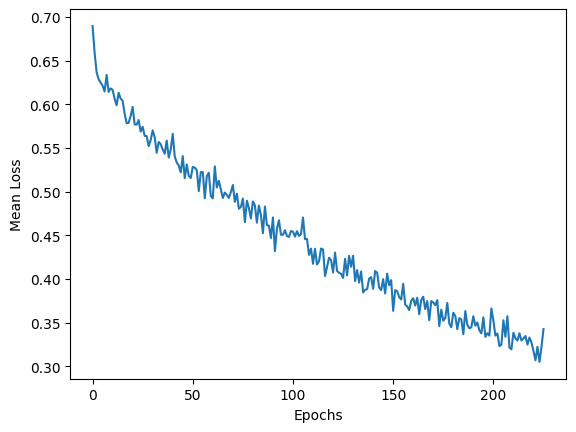

Epoch: 225, Loss: 0.34269243478775024


  5%|▌         | 250/5000 [09:58<3:01:01,  2.29s/it]

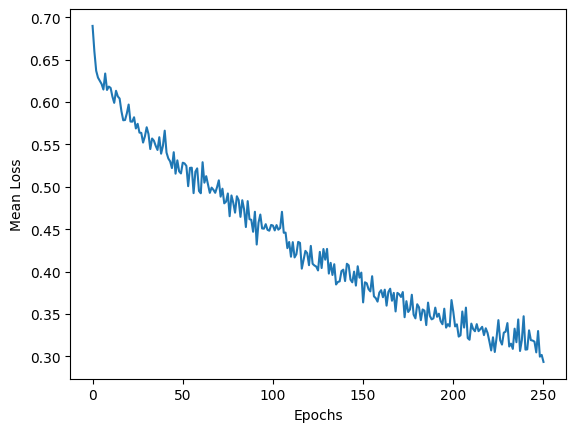

Epoch: 250, Loss: 0.2933720052242279


  6%|▌         | 275/5000 [10:55<3:01:33,  2.31s/it]

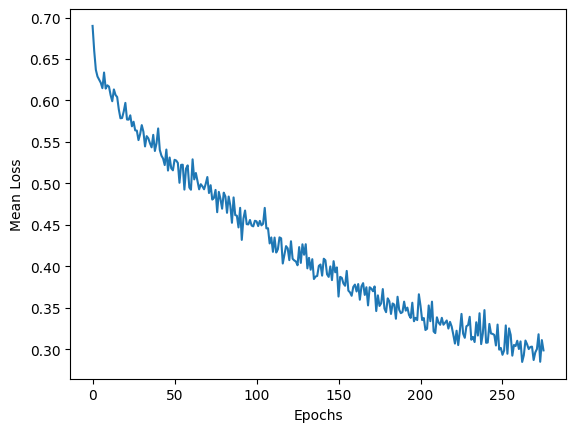

Epoch: 275, Loss: 0.2987110912799835


  6%|▌         | 300/5000 [11:53<3:03:55,  2.35s/it]

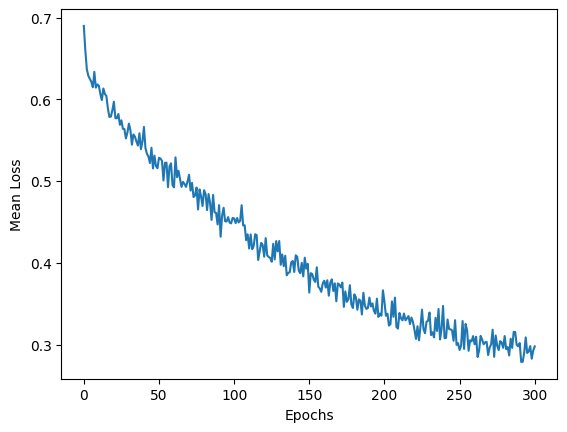

Epoch: 300, Loss: 0.2977127134799957


  6%|▋         | 325/5000 [12:50<2:55:24,  2.25s/it]

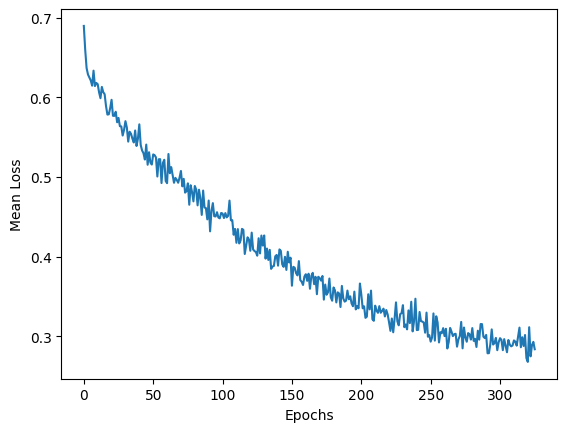

Epoch: 325, Loss: 0.28384464979171753


  7%|▋         | 350/5000 [13:49<2:55:20,  2.26s/it]

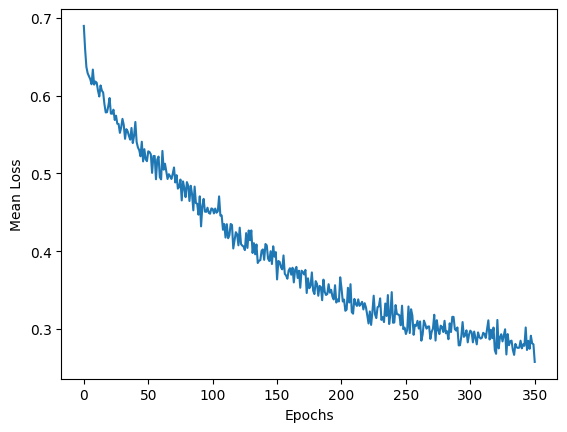

Epoch: 350, Loss: 0.25746625661849976


  8%|▊         | 375/5000 [14:47<2:56:28,  2.29s/it]

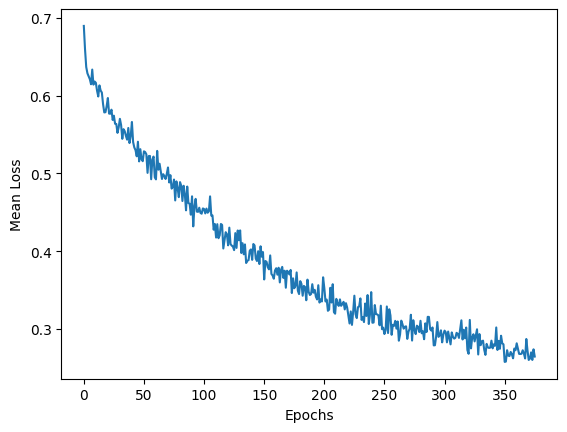

Epoch: 375, Loss: 0.2643788754940033


  8%|▊         | 400/5000 [15:44<2:55:00,  2.28s/it]

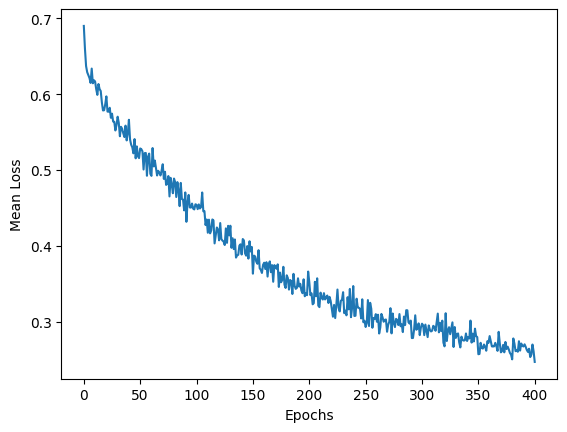

Epoch: 400, Loss: 0.24737222492694855


  8%|▊         | 425/5000 [16:43<3:08:37,  2.47s/it]

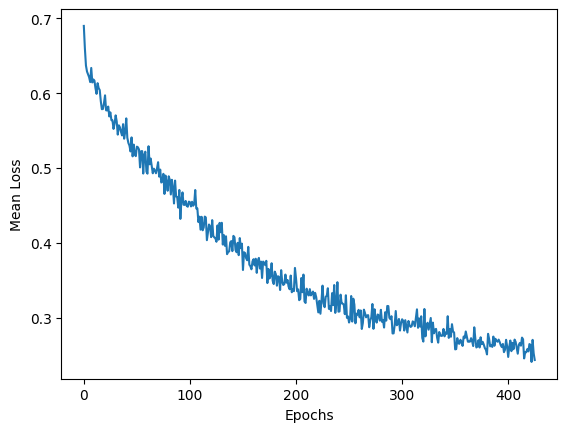

Epoch: 425, Loss: 0.2432975023984909


  9%|▉         | 450/5000 [17:41<2:50:09,  2.24s/it]

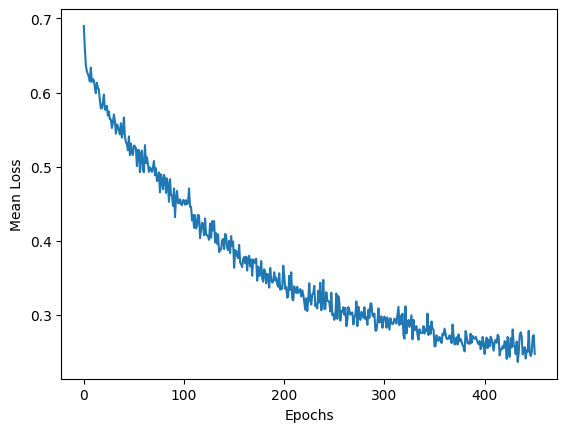

Epoch: 450, Loss: 0.24739901721477509


 10%|▉         | 475/5000 [18:39<2:47:49,  2.23s/it]

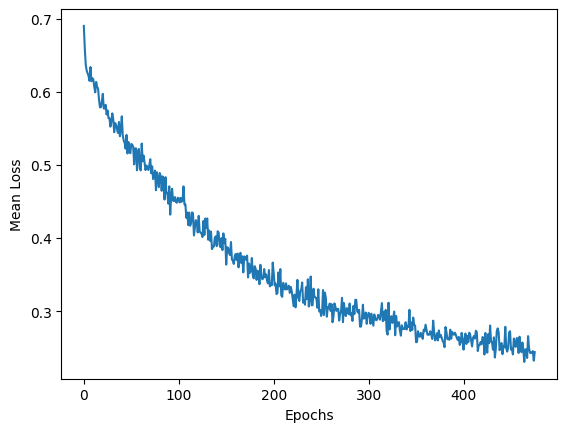

Epoch: 475, Loss: 0.24400410056114197


 10%|█         | 500/5000 [19:36<2:49:34,  2.26s/it]

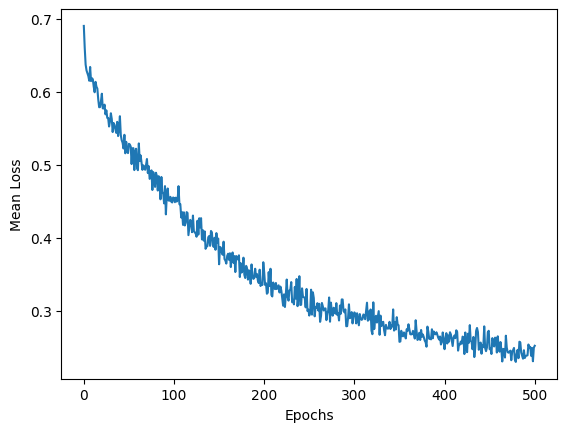

Epoch: 500, Loss: 0.2520168423652649


 10%|█         | 525/5000 [20:34<2:50:18,  2.28s/it]

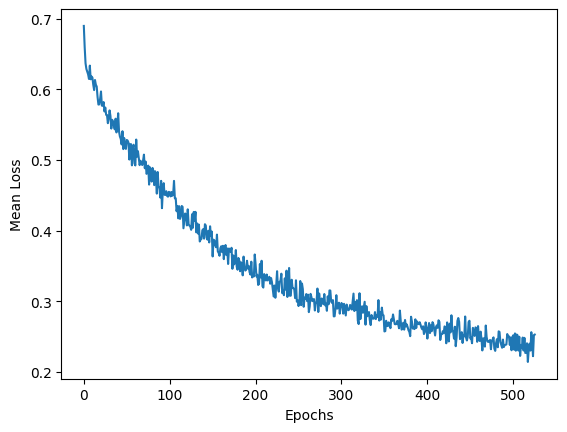

Epoch: 525, Loss: 0.25298836827278137


 11%|█         | 550/5000 [21:31<2:53:54,  2.34s/it]

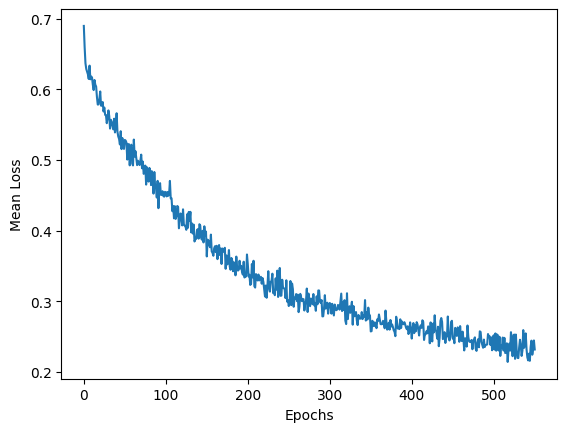

Epoch: 550, Loss: 0.23188748955726624


 12%|█▏        | 575/5000 [22:30<2:50:14,  2.31s/it]

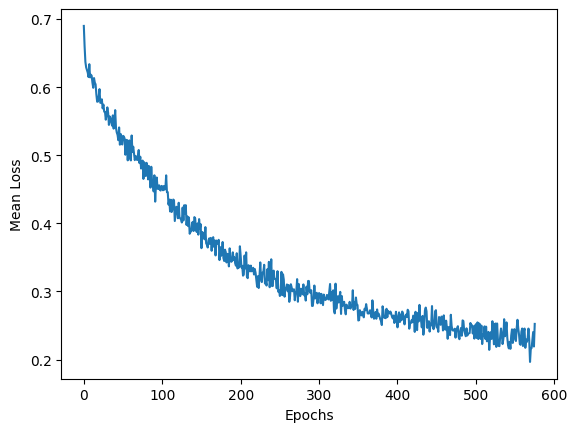

Epoch: 575, Loss: 0.2524186670780182


 12%|█▏        | 600/5000 [23:27<2:47:12,  2.28s/it]

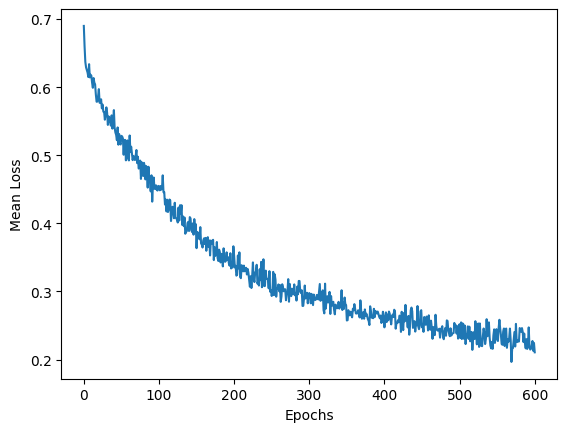

Epoch: 600, Loss: 0.21071818470954895


 12%|█▎        | 625/5000 [24:22<2:44:28,  2.26s/it]

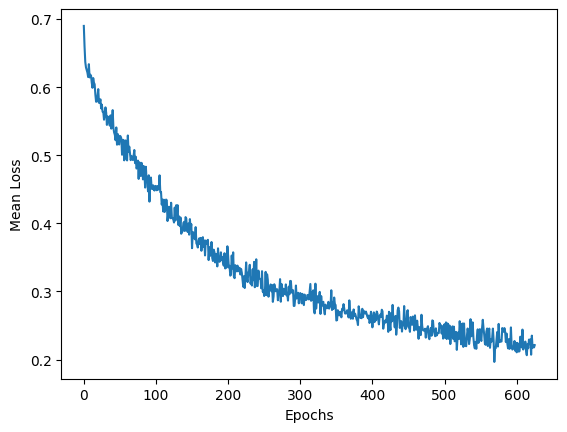

Epoch: 625, Loss: 0.2212580442428589


 13%|█▎        | 650/5000 [25:21<2:56:30,  2.43s/it]

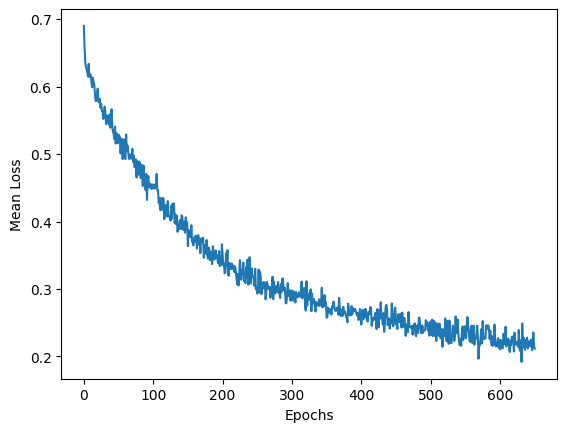

Epoch: 650, Loss: 0.21153800189495087


 14%|█▎        | 675/5000 [26:21<2:53:08,  2.40s/it]

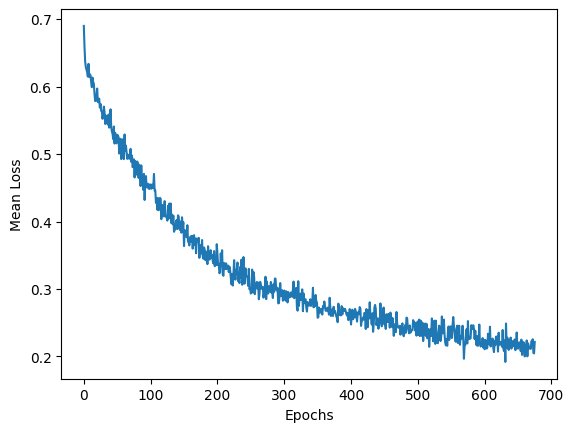

Epoch: 675, Loss: 0.22150781750679016


 14%|█▍        | 700/5000 [27:17<2:44:38,  2.30s/it]

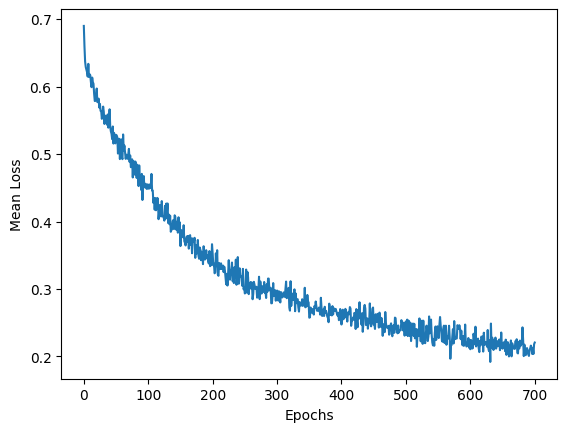

Epoch: 700, Loss: 0.22063091397285461


 14%|█▍        | 725/5000 [28:14<2:40:53,  2.26s/it]

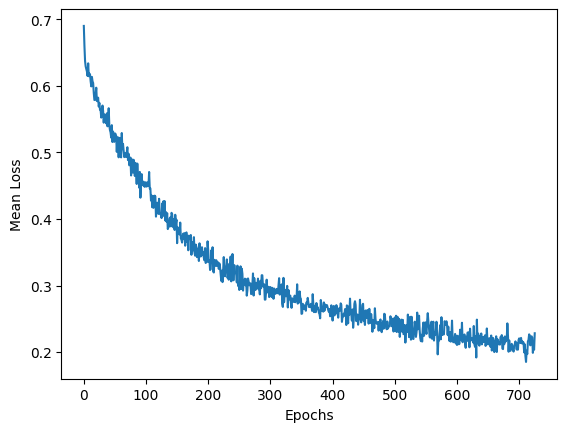

Epoch: 725, Loss: 0.22830264270305634


 15%|█▌        | 750/5000 [29:11<2:42:43,  2.30s/it]

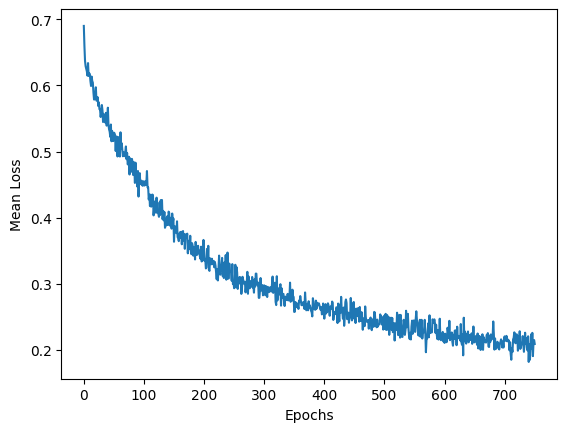

Epoch: 750, Loss: 0.2090926617383957


 16%|█▌        | 775/5000 [30:09<2:37:37,  2.24s/it]

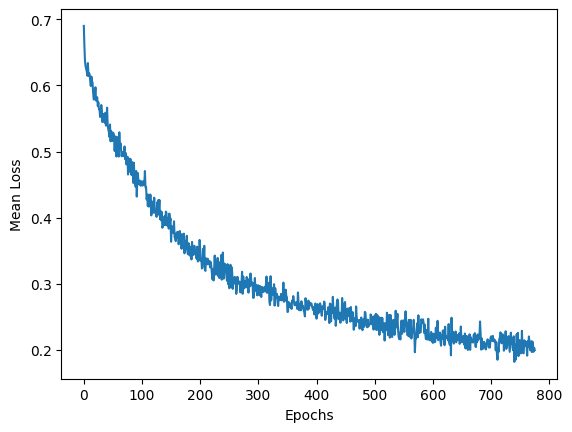

Epoch: 775, Loss: 0.19973382353782654


 16%|█▌        | 800/5000 [31:06<2:38:52,  2.27s/it]

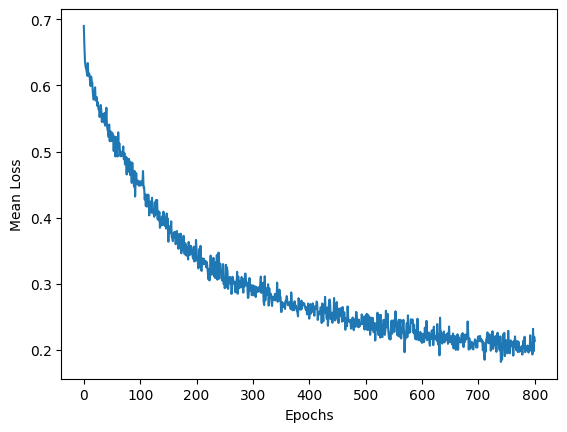

Epoch: 800, Loss: 0.2134629189968109


 16%|█▋        | 825/5000 [32:02<2:35:38,  2.24s/it]

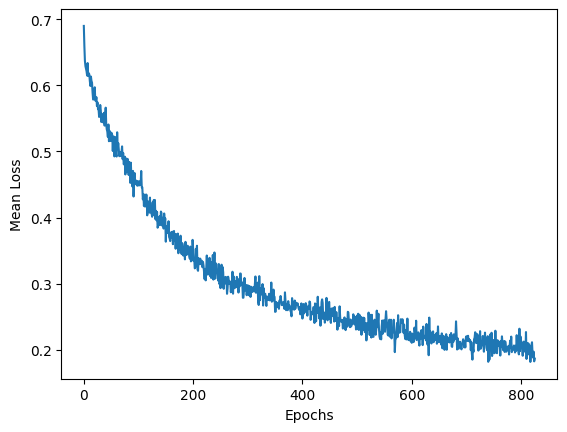

Epoch: 825, Loss: 0.18685436248779297


 17%|█▋        | 850/5000 [32:58<2:33:33,  2.22s/it]

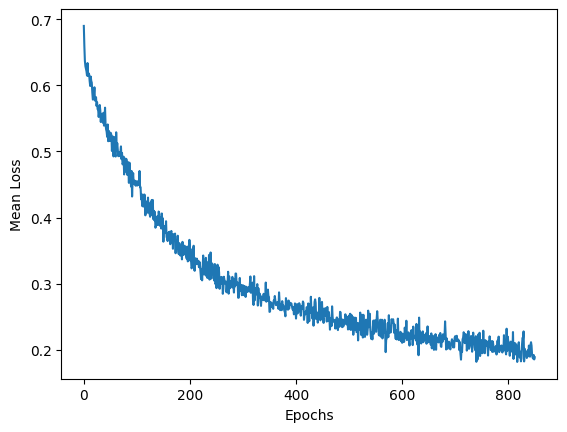

Epoch: 850, Loss: 0.18892958760261536


 18%|█▊        | 875/5000 [33:56<2:47:25,  2.44s/it]

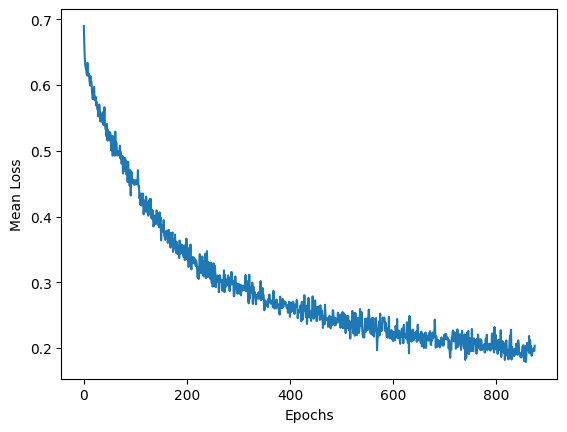

Epoch: 875, Loss: 0.20347881317138672


 18%|█▊        | 900/5000 [34:57<2:37:46,  2.31s/it]

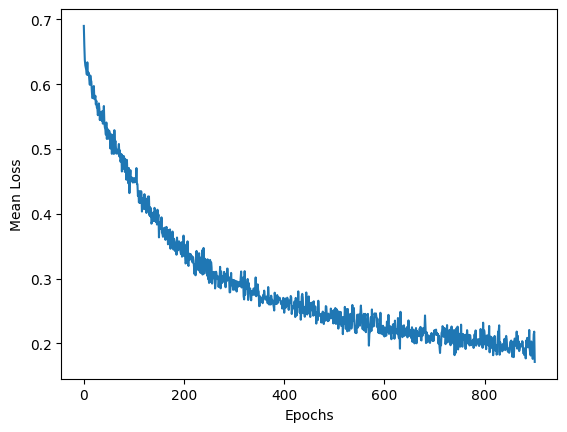

Epoch: 900, Loss: 0.17146167159080505


 18%|█▊        | 925/5000 [35:55<2:44:25,  2.42s/it]

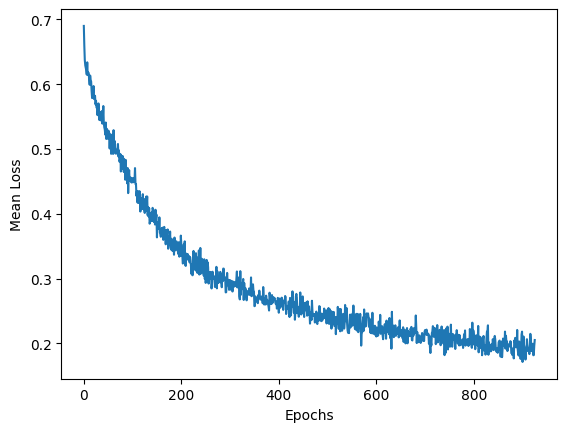

Epoch: 925, Loss: 0.20525947213172913


 19%|█▉        | 950/5000 [36:54<2:36:46,  2.32s/it]

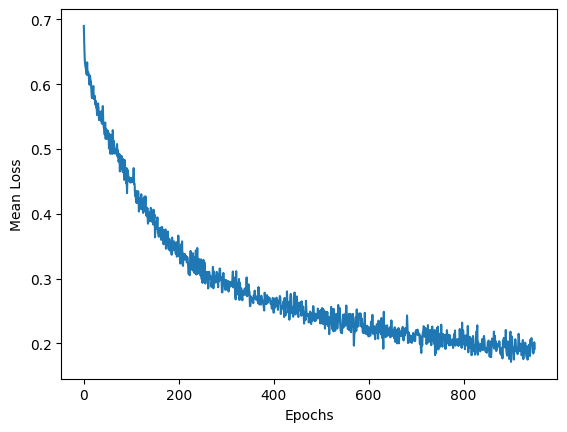

Epoch: 950, Loss: 0.19188722968101501


 20%|█▉        | 975/5000 [37:53<2:39:36,  2.38s/it]

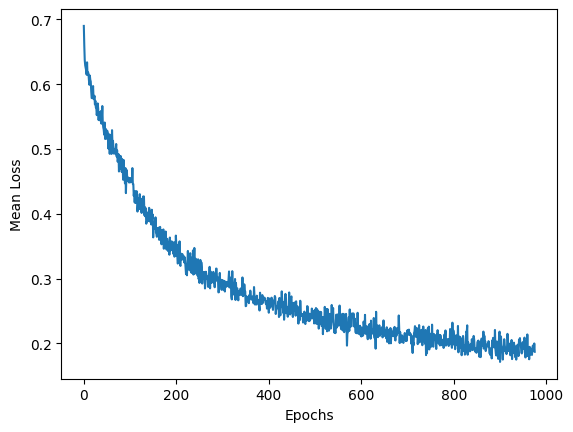

Epoch: 975, Loss: 0.18708398938179016


 20%|██        | 1000/5000 [38:53<2:33:40,  2.31s/it]

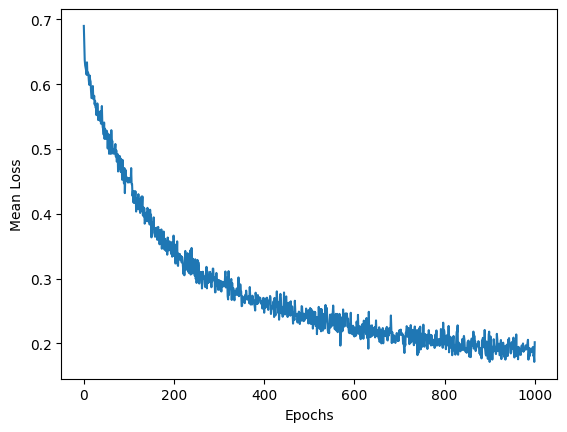

Epoch: 1000, Loss: 0.2018374651670456


 20%|██        | 1025/5000 [39:53<2:41:25,  2.44s/it]

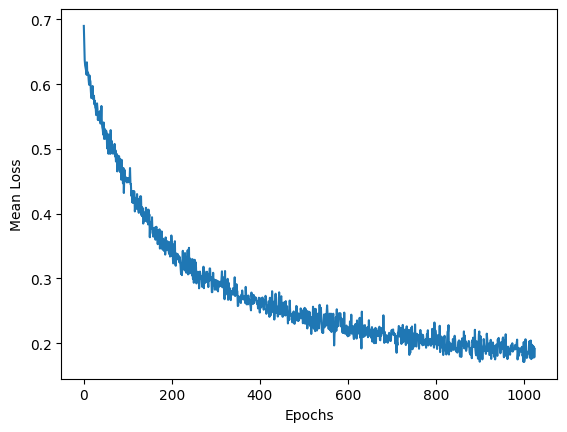

Epoch: 1025, Loss: 0.19142012298107147


 21%|██        | 1050/5000 [40:53<2:42:34,  2.47s/it]

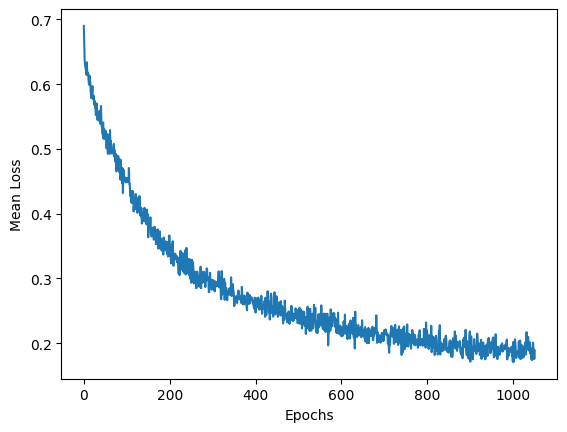

Epoch: 1050, Loss: 0.18881158530712128


 22%|██▏       | 1075/5000 [41:58<2:46:15,  2.54s/it]

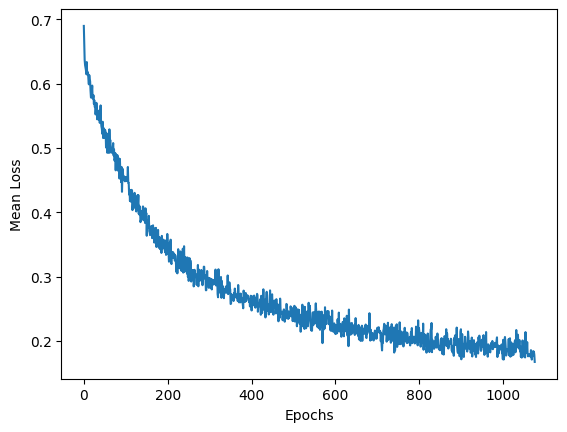

Epoch: 1075, Loss: 0.16738197207450867


 22%|██▏       | 1100/5000 [42:59<2:46:18,  2.56s/it]

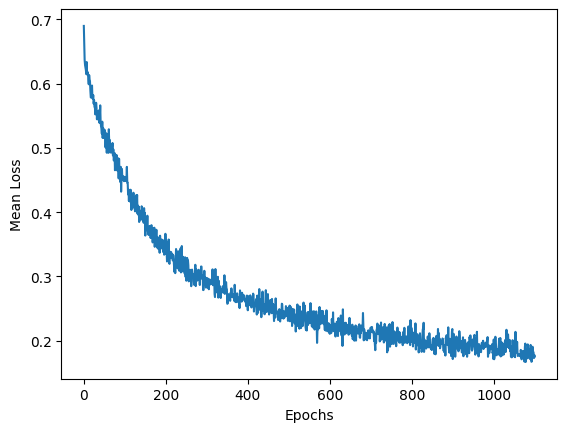

Epoch: 1100, Loss: 0.17528244853019714


 22%|██▎       | 1125/5000 [44:02<2:31:42,  2.35s/it]

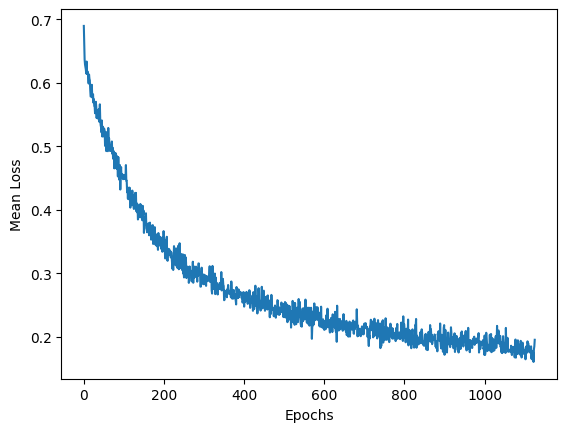

Epoch: 1125, Loss: 0.1950744390487671


 23%|██▎       | 1150/5000 [45:01<2:24:23,  2.25s/it]

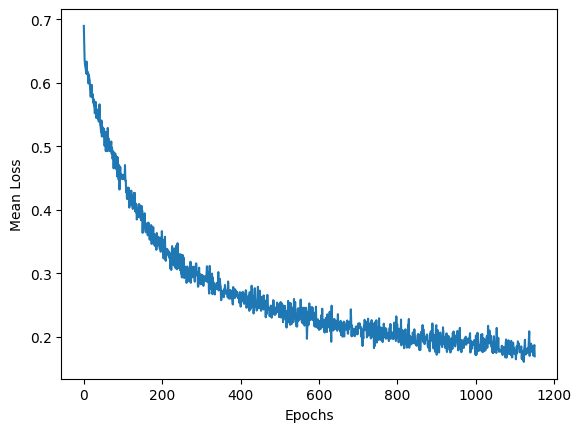

Epoch: 1150, Loss: 0.1690608561038971


 24%|██▎       | 1175/5000 [46:00<2:28:47,  2.33s/it]

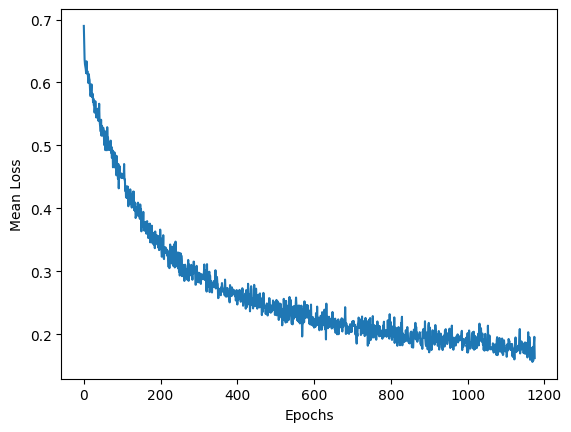

Epoch: 1175, Loss: 0.16228607296943665


 24%|██▍       | 1200/5000 [47:00<2:30:18,  2.37s/it]

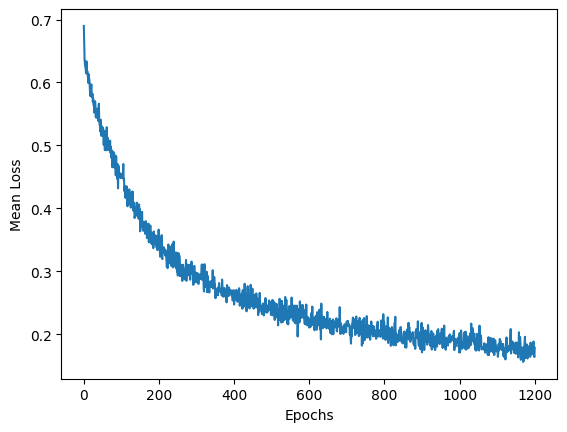

Epoch: 1200, Loss: 0.17871545255184174


 24%|██▍       | 1225/5000 [48:00<2:20:49,  2.24s/it]

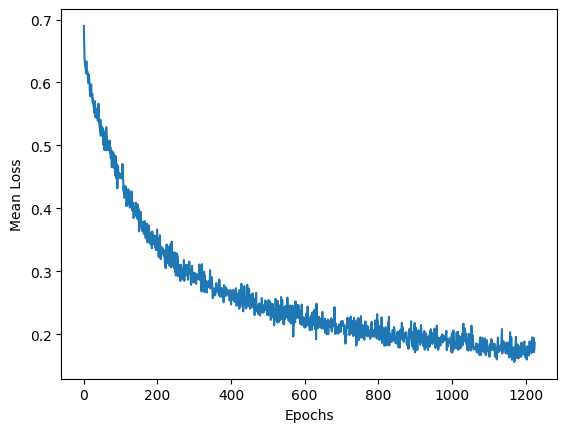

Epoch: 1225, Loss: 0.18632642924785614


 25%|██▌       | 1250/5000 [48:58<2:35:50,  2.49s/it]

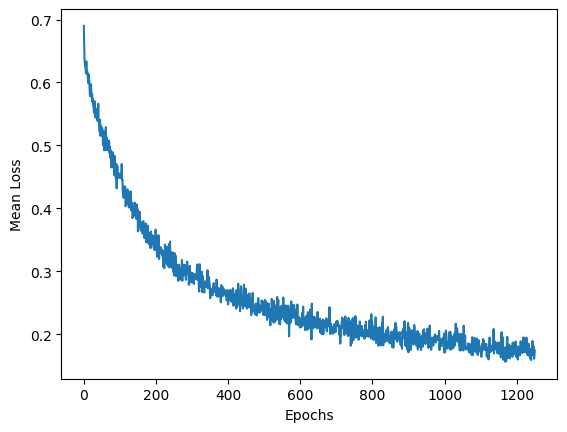

Epoch: 1250, Loss: 0.17455264925956726


 26%|██▌       | 1275/5000 [49:59<2:34:03,  2.48s/it]

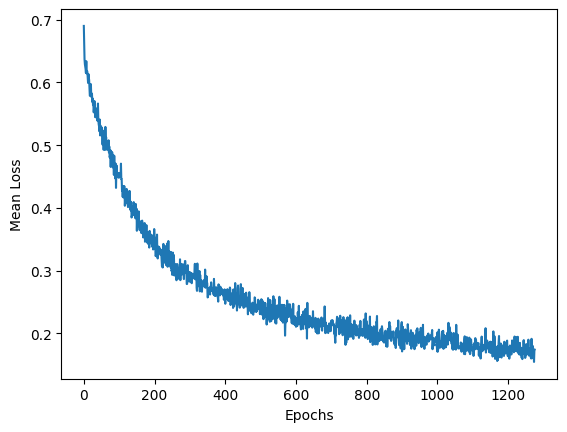

Epoch: 1275, Loss: 0.17425449192523956


 26%|██▌       | 1300/5000 [50:59<2:24:10,  2.34s/it]

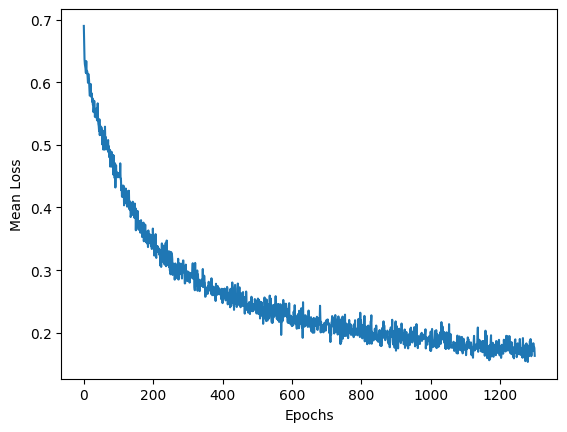

Epoch: 1300, Loss: 0.1631697118282318


 26%|██▋       | 1325/5000 [51:58<2:20:09,  2.29s/it]

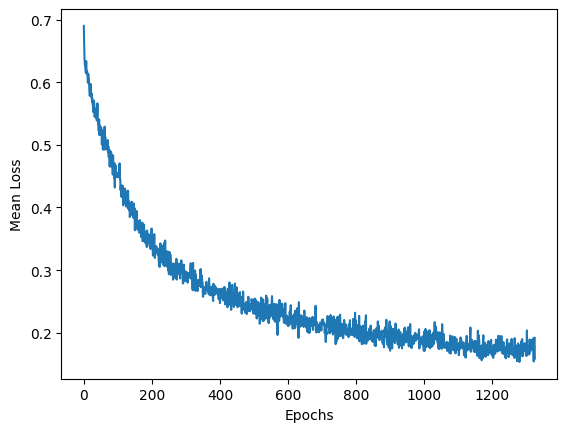

Epoch: 1325, Loss: 0.19195163249969482


 27%|██▋       | 1350/5000 [52:58<2:24:09,  2.37s/it]

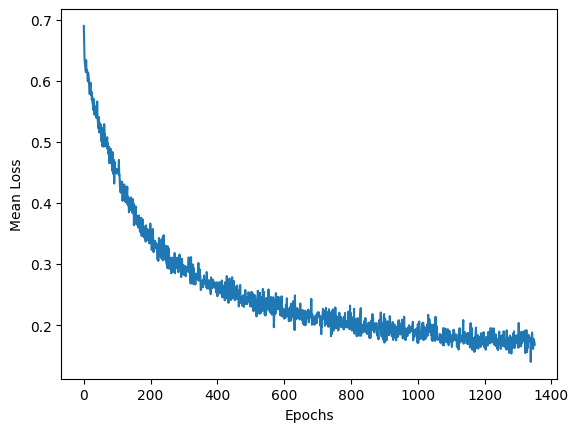

Epoch: 1350, Loss: 0.16806380450725555


 28%|██▊       | 1375/5000 [53:55<2:16:30,  2.26s/it]

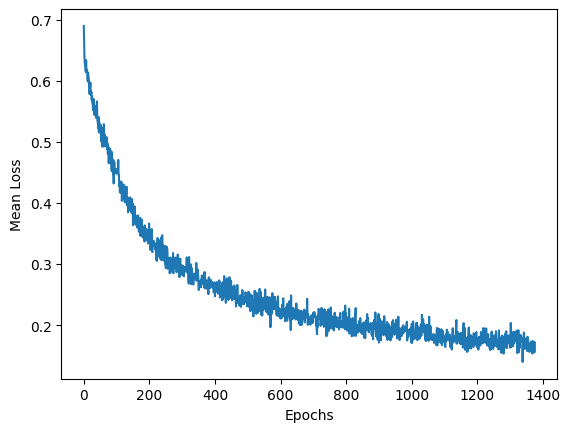

Epoch: 1375, Loss: 0.17159844934940338


 28%|██▊       | 1400/5000 [54:54<2:17:47,  2.30s/it]

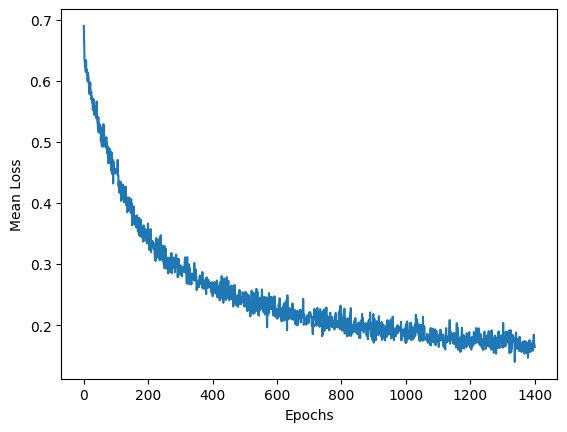

Epoch: 1400, Loss: 0.16411688923835754


 28%|██▊       | 1425/5000 [55:53<2:19:21,  2.34s/it]

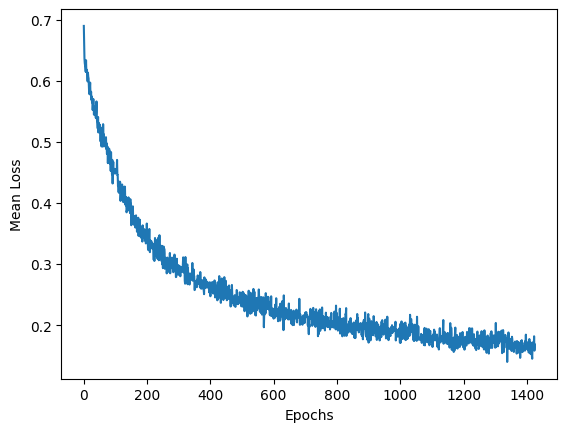

Epoch: 1425, Loss: 0.16835007071495056


 29%|██▉       | 1450/5000 [56:52<2:18:19,  2.34s/it]

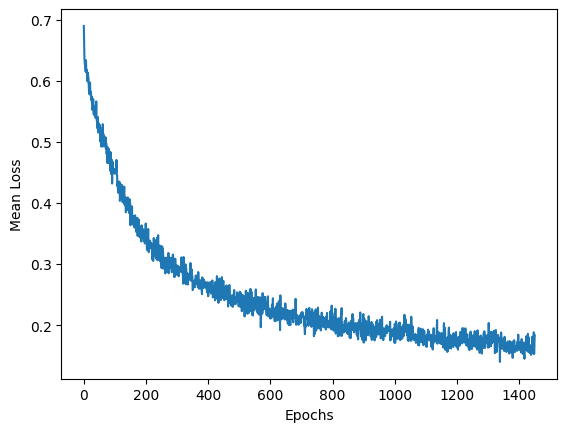

Epoch: 1450, Loss: 0.18353267014026642


 30%|██▉       | 1475/5000 [57:51<2:20:14,  2.39s/it]

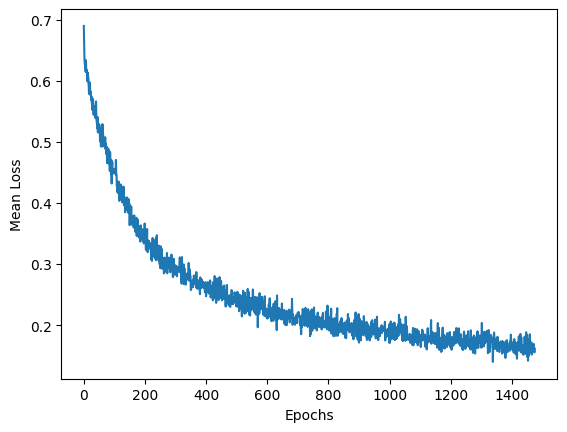

Epoch: 1475, Loss: 0.1615251749753952


 30%|███       | 1500/5000 [58:49<2:15:46,  2.33s/it]

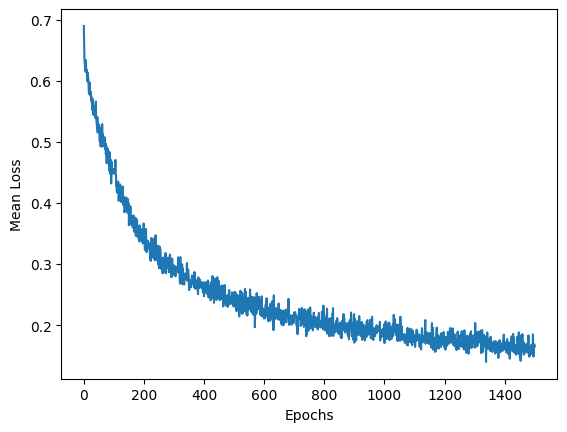

Epoch: 1500, Loss: 0.1651689112186432


 30%|███       | 1525/5000 [59:48<2:19:45,  2.41s/it]

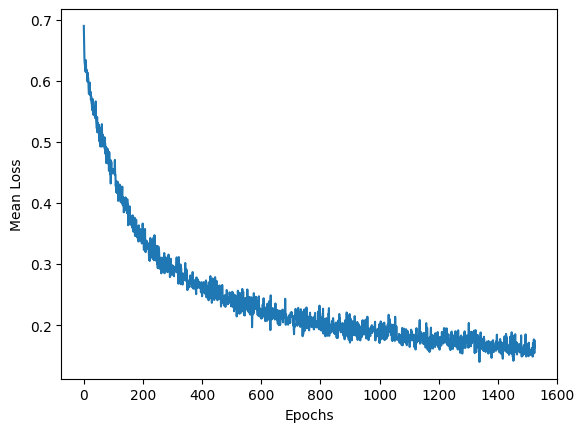

Epoch: 1525, Loss: 0.15569886565208435


 31%|███       | 1550/5000 [1:00:47<2:11:46,  2.29s/it]

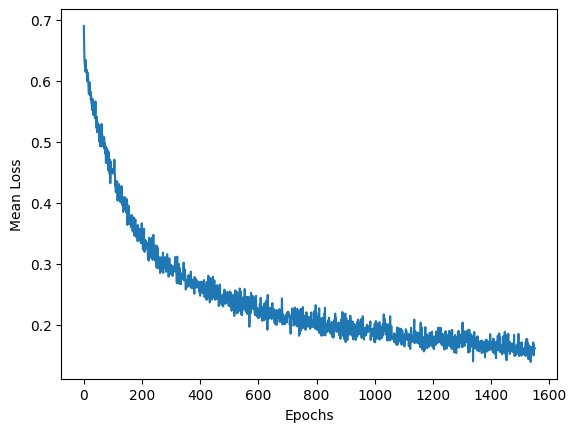

Epoch: 1550, Loss: 0.16156433522701263


 32%|███▏      | 1575/5000 [1:01:44<2:10:45,  2.29s/it]

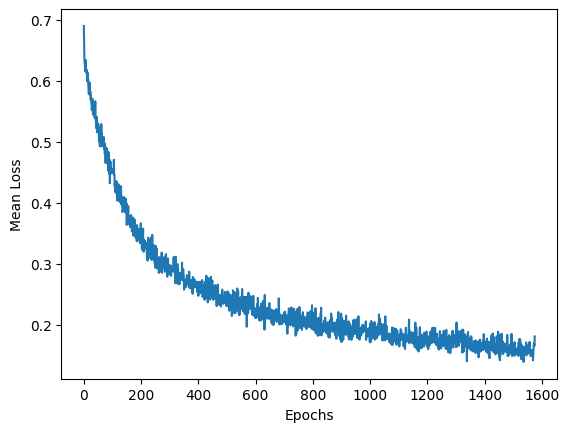

Epoch: 1575, Loss: 0.18068517744541168


 32%|███▏      | 1600/5000 [1:02:41<2:08:43,  2.27s/it]

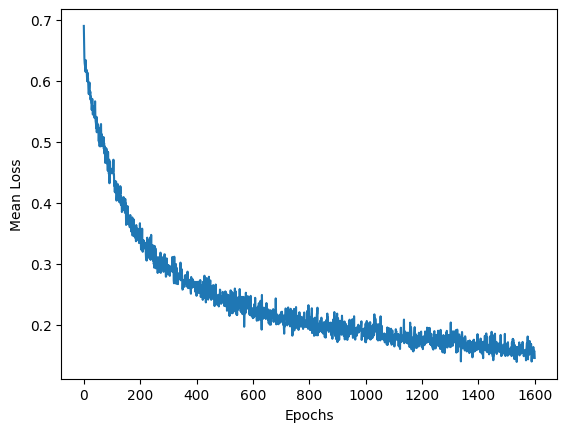

Epoch: 1600, Loss: 0.14542484283447266


 32%|███▎      | 1625/5000 [1:03:38<2:10:53,  2.33s/it]

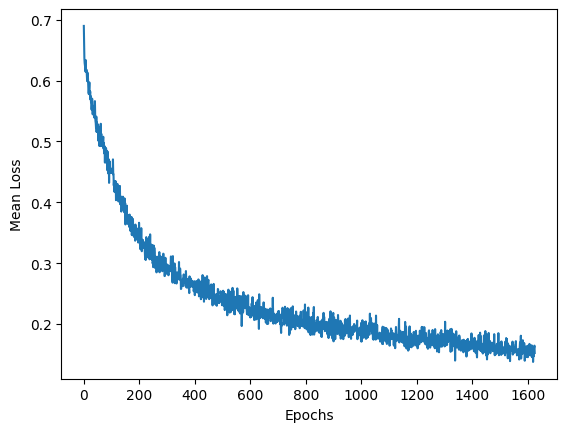

Epoch: 1625, Loss: 0.1522817462682724


 33%|███▎      | 1650/5000 [1:04:36<2:05:02,  2.24s/it]

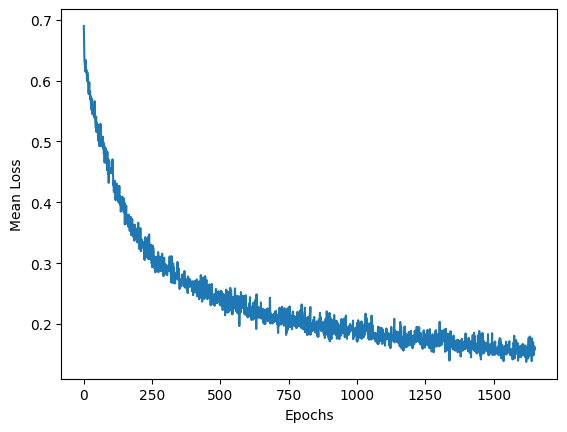

Epoch: 1650, Loss: 0.160936638712883


 34%|███▎      | 1675/5000 [1:05:35<2:17:46,  2.49s/it]

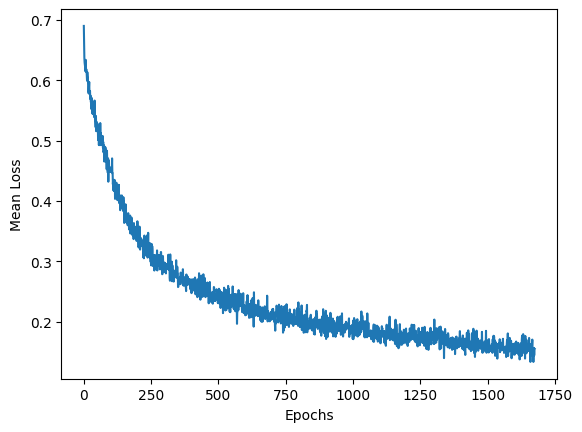

Epoch: 1675, Loss: 0.1551368534564972


 34%|███▍      | 1700/5000 [1:06:40<2:23:22,  2.61s/it]

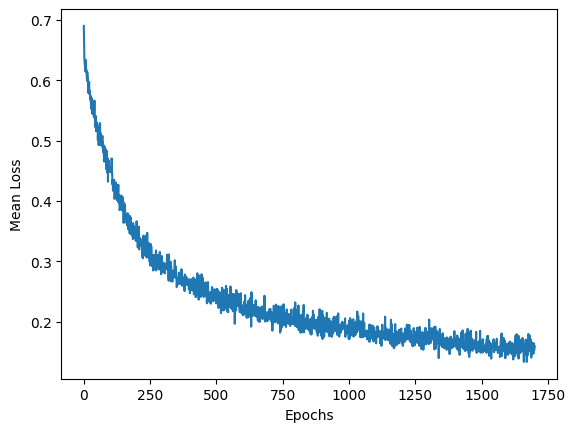

Epoch: 1700, Loss: 0.15940062701702118


 34%|███▍      | 1725/5000 [1:07:44<2:11:37,  2.41s/it]

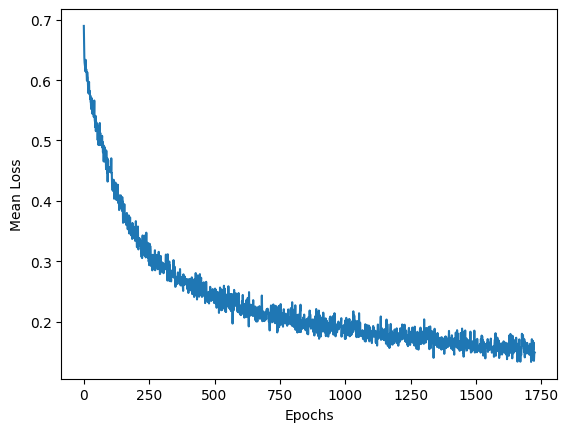

Epoch: 1725, Loss: 0.14875680208206177


 35%|███▌      | 1750/5000 [1:08:45<2:14:30,  2.48s/it]

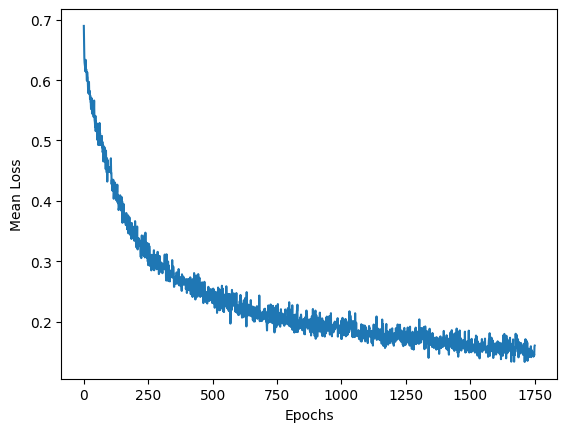

Epoch: 1750, Loss: 0.16012272238731384


 36%|███▌      | 1775/5000 [1:09:47<2:15:29,  2.52s/it]

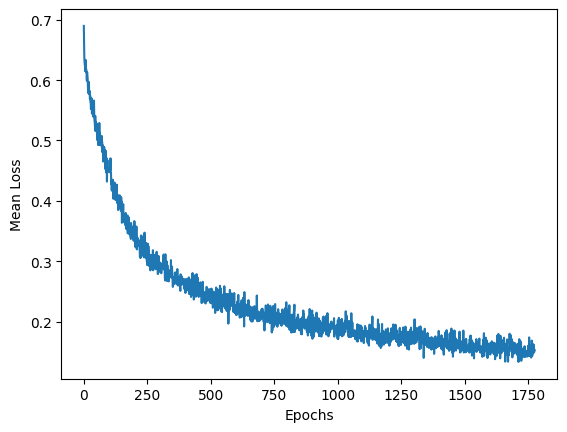

Epoch: 1775, Loss: 0.15260128676891327


 36%|███▌      | 1800/5000 [1:10:49<2:08:54,  2.42s/it]

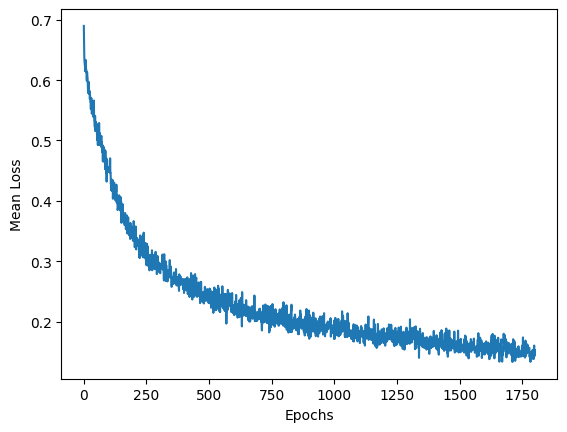

Epoch: 1800, Loss: 0.15264026820659637


 36%|███▋      | 1825/5000 [1:11:51<2:13:21,  2.52s/it]

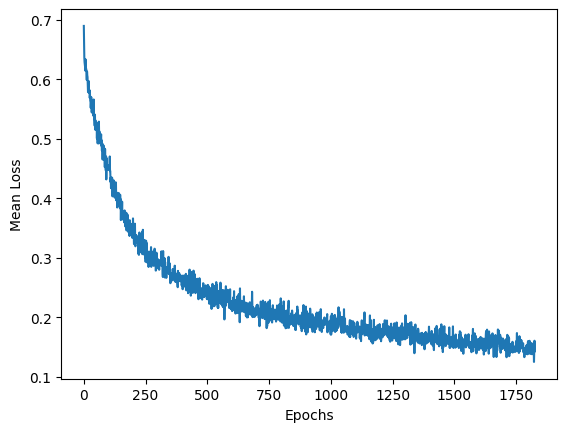

Epoch: 1825, Loss: 0.1430208384990692


 37%|███▋      | 1850/5000 [1:12:51<2:04:46,  2.38s/it]

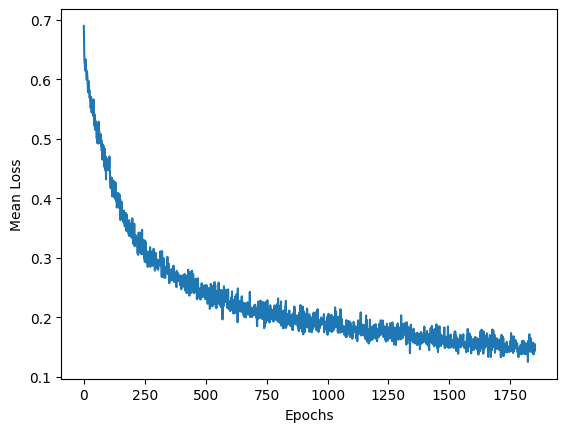

Epoch: 1850, Loss: 0.14437508583068848


 38%|███▊      | 1875/5000 [1:13:51<2:04:39,  2.39s/it]

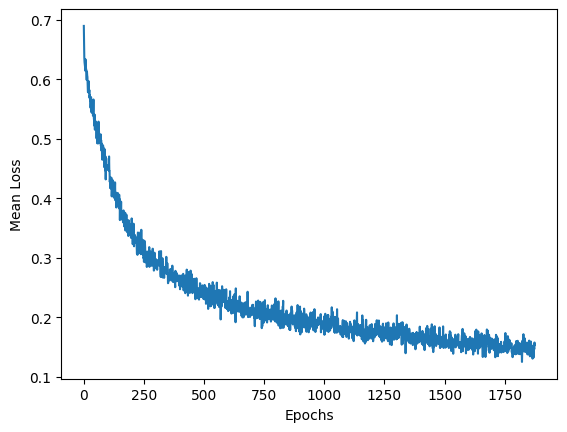

Epoch: 1875, Loss: 0.15334871411323547


 38%|███▊      | 1900/5000 [1:14:51<2:05:34,  2.43s/it]

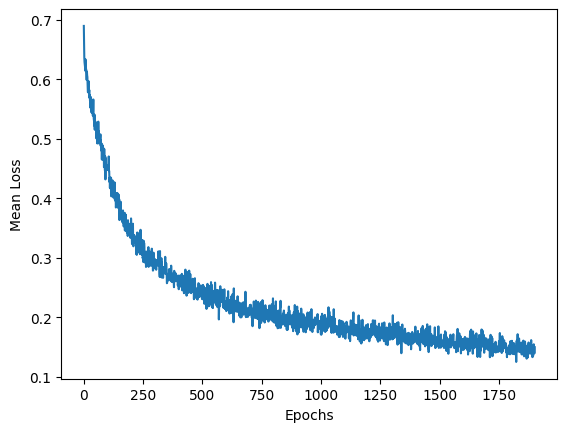

Epoch: 1900, Loss: 0.15004342794418335


 38%|███▊      | 1925/5000 [1:15:50<1:55:48,  2.26s/it]

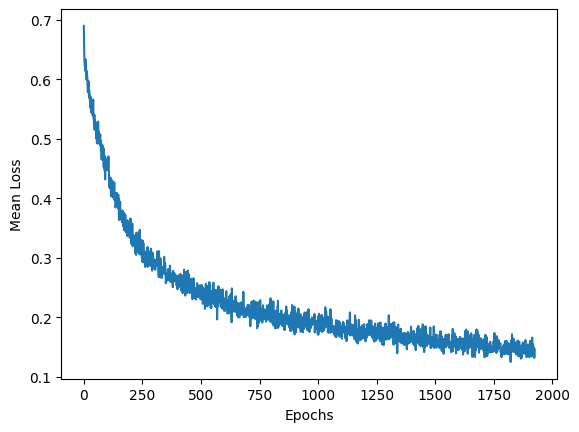

Epoch: 1925, Loss: 0.14615139365196228


 39%|███▉      | 1950/5000 [1:16:45<1:52:17,  2.21s/it]

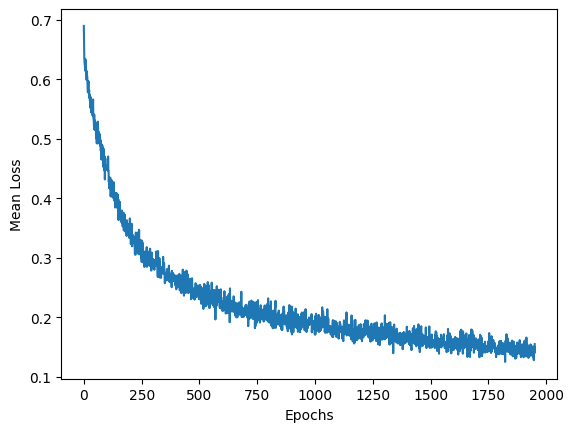

Epoch: 1950, Loss: 0.15513870120048523


 40%|███▉      | 1975/5000 [1:17:42<1:56:09,  2.30s/it]

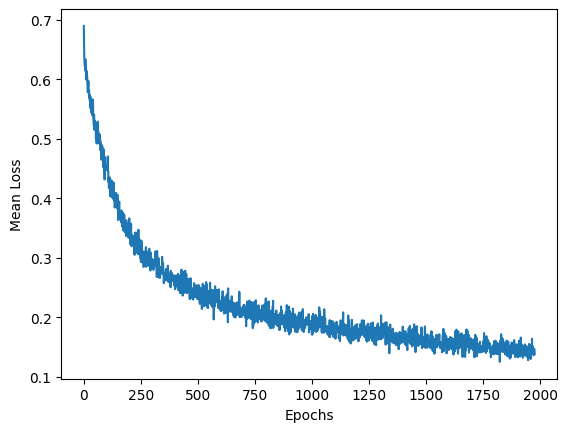

Epoch: 1975, Loss: 0.13830013573169708


 40%|████      | 2000/5000 [1:18:40<1:55:11,  2.30s/it]

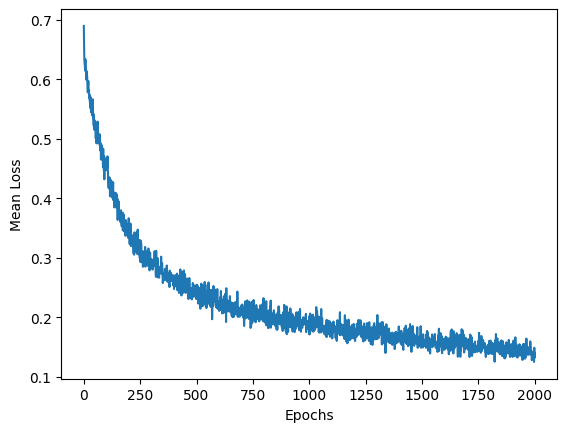

Epoch: 2000, Loss: 0.1399175524711609


 40%|████      | 2025/5000 [1:21:41<10:53:00, 13.17s/it]

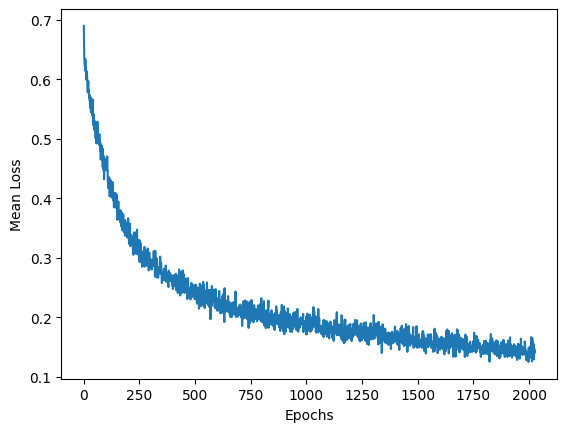

Epoch: 2025, Loss: 0.1430991291999817


 41%|████      | 2050/5000 [2:11:19<238:58:29, 291.63s/it]

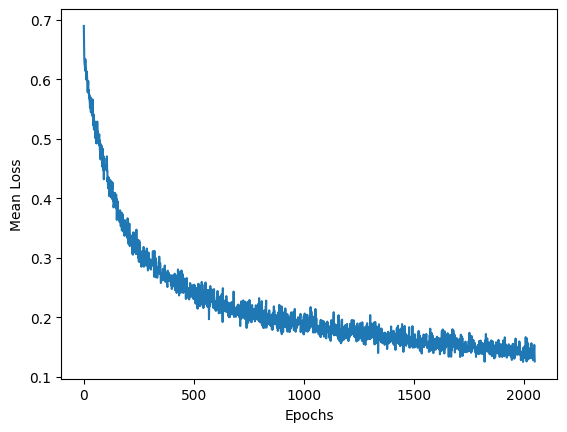

Epoch: 2050, Loss: 0.12564530968666077


 42%|████▏     | 2075/5000 [2:17:42<9:41:33, 11.93s/it]   

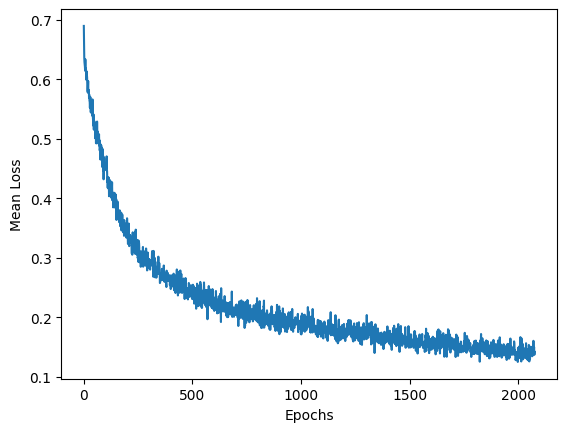

Epoch: 2075, Loss: 0.1417389214038849


 42%|████▏     | 2100/5000 [3:06:13<209:32:33, 260.12s/it]

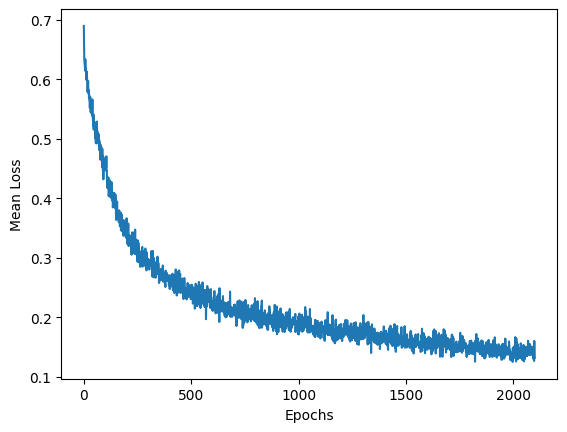

Epoch: 2100, Loss: 0.13185465335845947


 42%|████▎     | 2125/5000 [4:55:11<156:56:44, 196.52s/it]

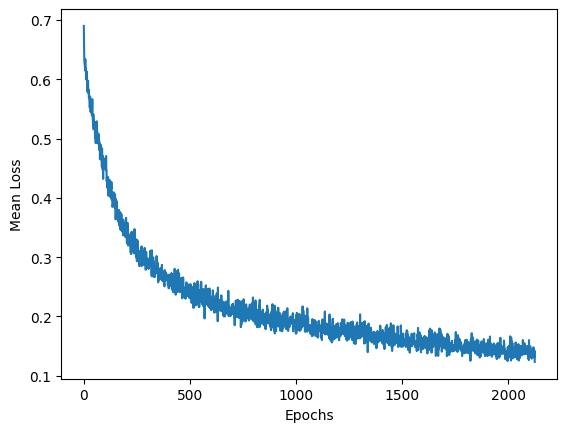

Epoch: 2125, Loss: 0.12333379685878754


 43%|████▎     | 2150/5000 [5:07:04<3:00:22,  3.80s/it]   

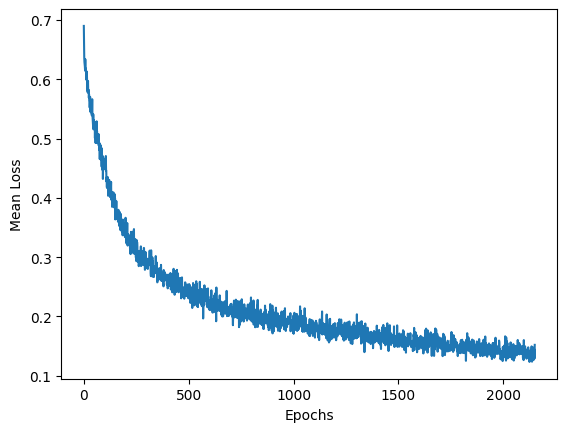

Epoch: 2150, Loss: 0.15211030840873718


 44%|████▎     | 2175/5000 [5:20:11<8:24:17, 10.71s/it]   

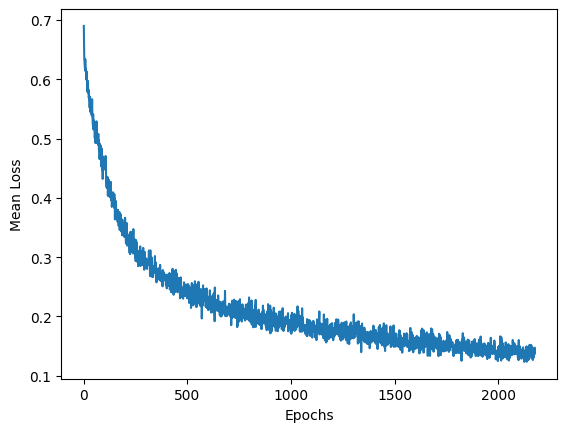

Epoch: 2175, Loss: 0.1470518559217453


 44%|████▍     | 2200/5000 [5:26:10<2:11:33,  2.82s/it] 

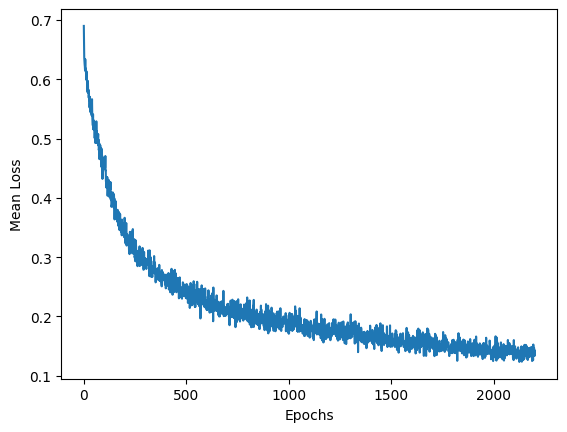

Epoch: 2200, Loss: 0.14235202968120575


 44%|████▍     | 2225/5000 [5:27:12<1:57:05,  2.53s/it]

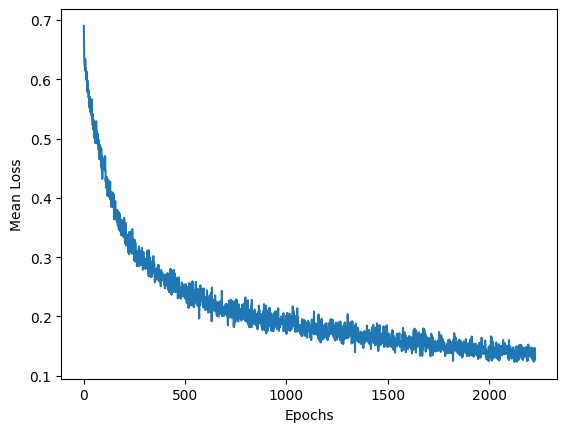

Epoch: 2225, Loss: 0.12770742177963257


 45%|████▌     | 2250/5000 [5:28:11<1:45:40,  2.31s/it]

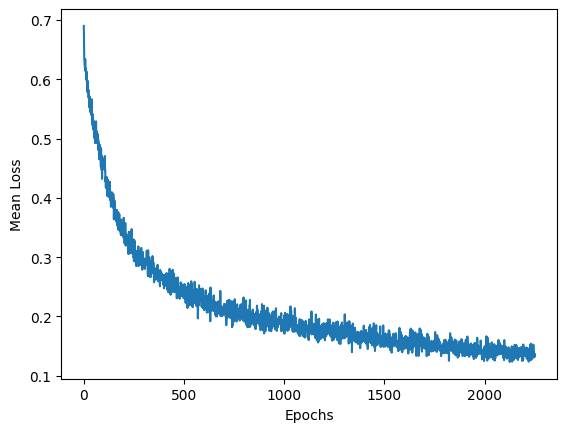

Epoch: 2250, Loss: 0.1364148110151291


 46%|████▌     | 2275/5000 [5:29:11<1:45:32,  2.32s/it]

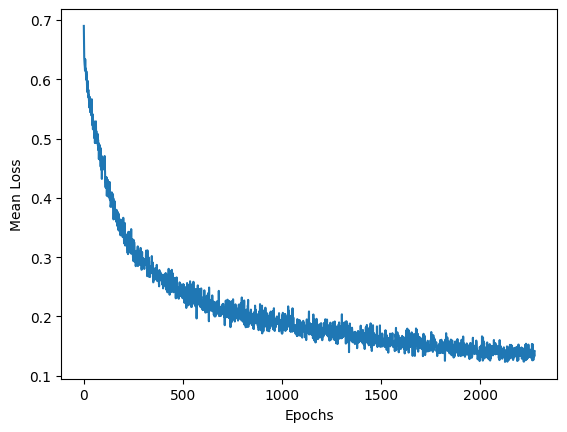

Epoch: 2275, Loss: 0.14131243526935577


 46%|████▌     | 2300/5000 [5:30:10<1:45:03,  2.33s/it]

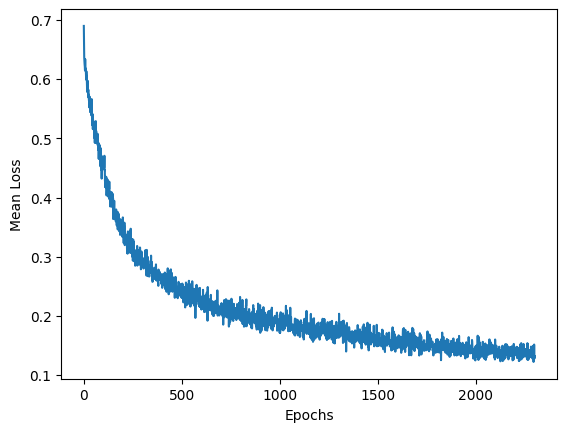

Epoch: 2300, Loss: 0.13183197379112244


 46%|████▋     | 2325/5000 [5:31:09<1:47:43,  2.42s/it]

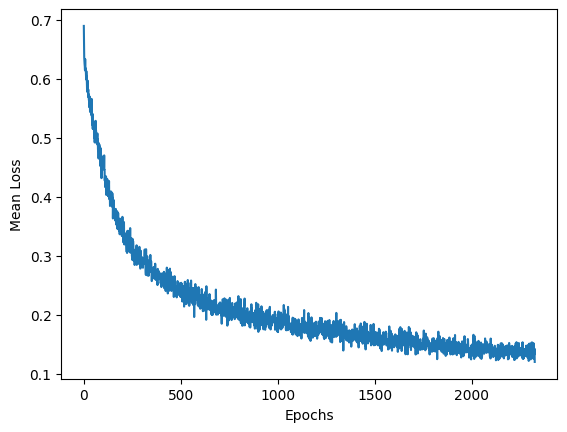

Epoch: 2325, Loss: 0.1205417662858963


 47%|████▋     | 2350/5000 [5:32:08<1:43:43,  2.35s/it]

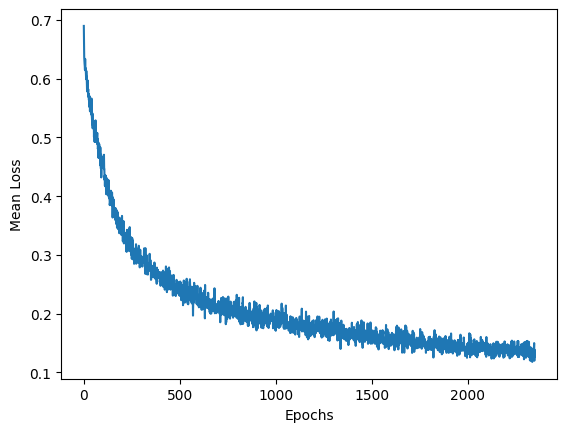

Epoch: 2350, Loss: 0.12629157304763794


 48%|████▊     | 2375/5000 [5:33:08<1:42:51,  2.35s/it]

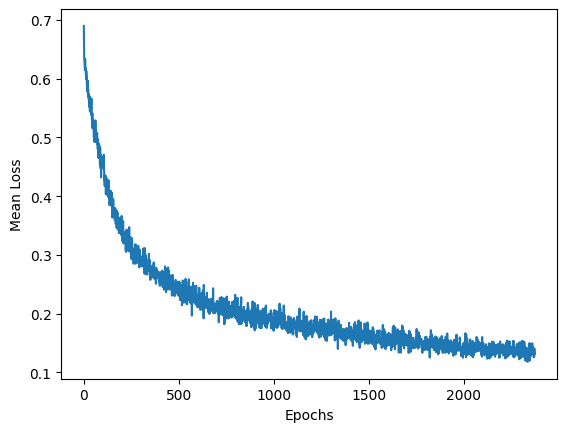

Epoch: 2375, Loss: 0.13315759599208832


 48%|████▊     | 2400/5000 [5:34:07<1:42:08,  2.36s/it]

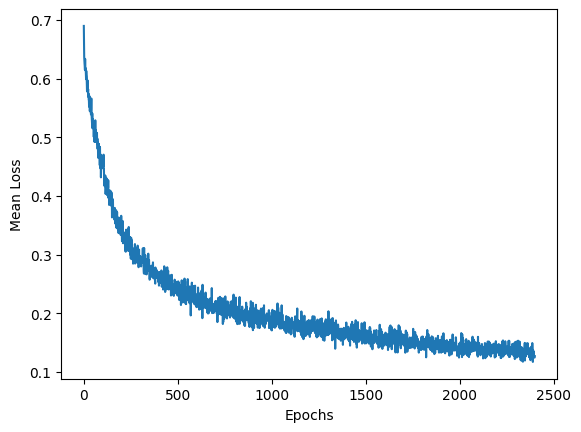

Epoch: 2400, Loss: 0.12745845317840576


 48%|████▊     | 2425/5000 [5:35:08<1:43:50,  2.42s/it]

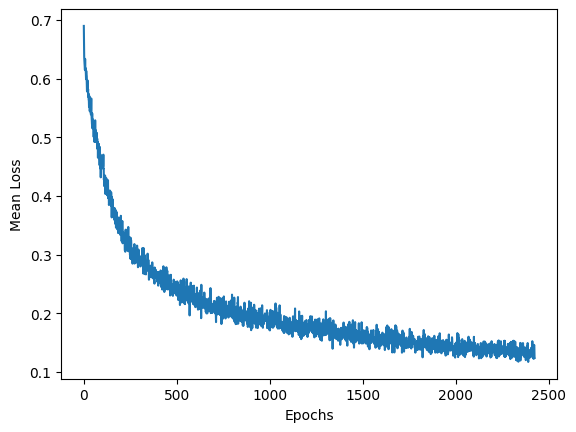

Epoch: 2425, Loss: 0.12417463958263397


 49%|████▉     | 2450/5000 [5:36:08<1:47:03,  2.52s/it]

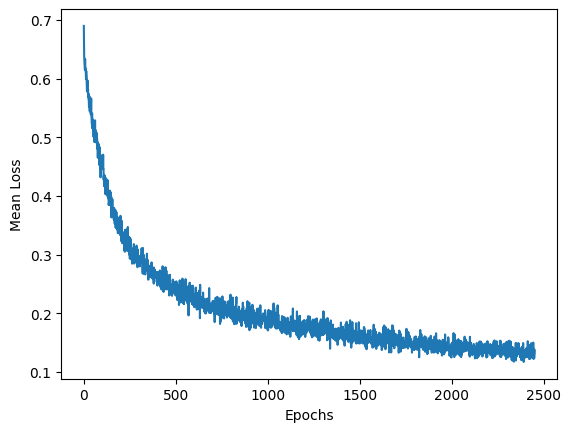

Epoch: 2450, Loss: 0.137151300907135


 50%|████▉     | 2475/5000 [5:37:08<1:41:09,  2.40s/it]

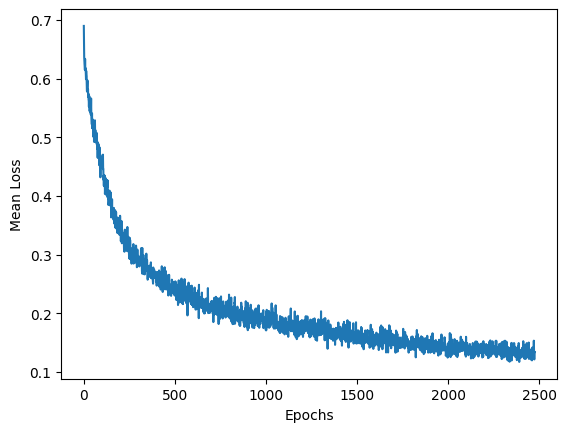

Epoch: 2475, Loss: 0.13451535999774933


 50%|█████     | 2500/5000 [5:38:09<1:39:14,  2.38s/it]

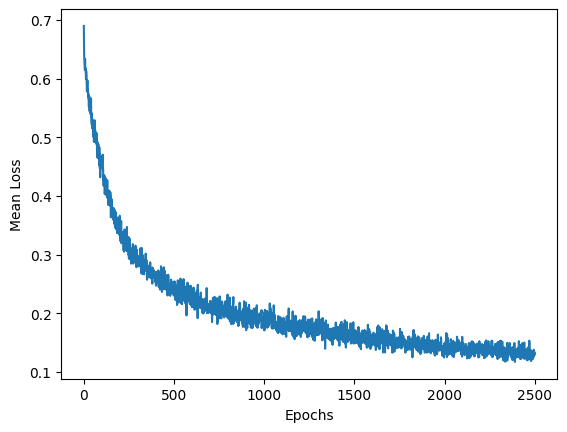

Epoch: 2500, Loss: 0.13022853434085846


 50%|█████     | 2525/5000 [5:39:09<1:39:15,  2.41s/it]

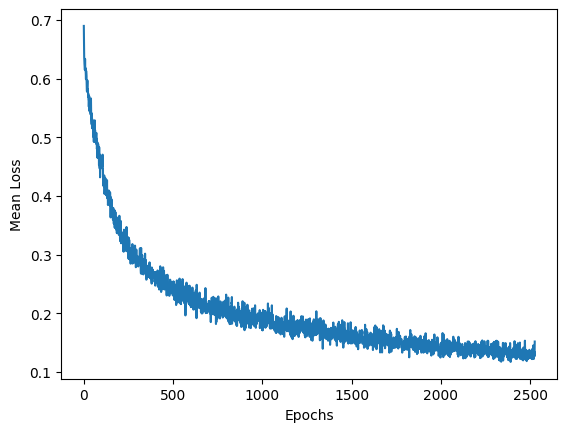

Epoch: 2525, Loss: 0.1520874947309494


 51%|█████     | 2550/5000 [5:40:10<1:43:45,  2.54s/it]

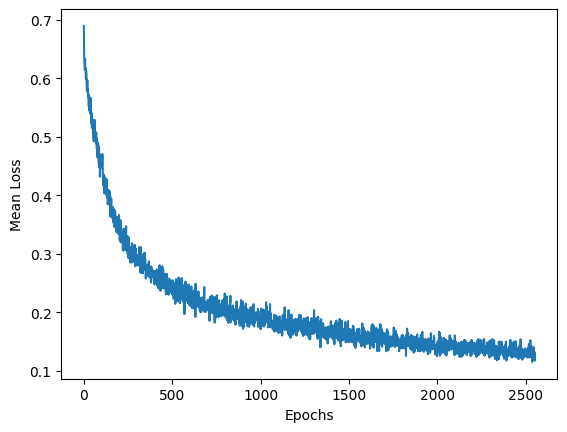

Epoch: 2550, Loss: 0.1308499276638031


 52%|█████▏    | 2575/5000 [5:41:10<1:37:32,  2.41s/it]

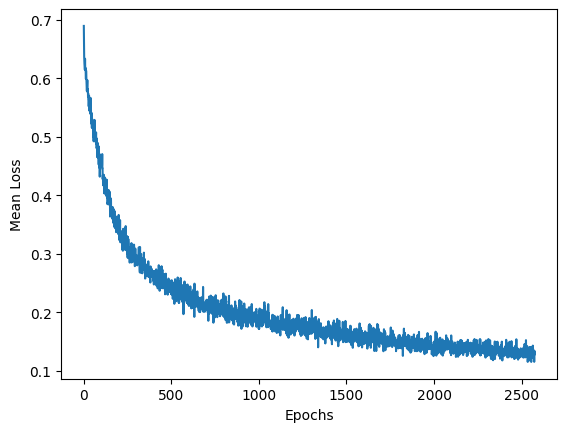

Epoch: 2575, Loss: 0.13089922070503235


 52%|█████▏    | 2600/5000 [5:42:11<1:35:39,  2.39s/it]

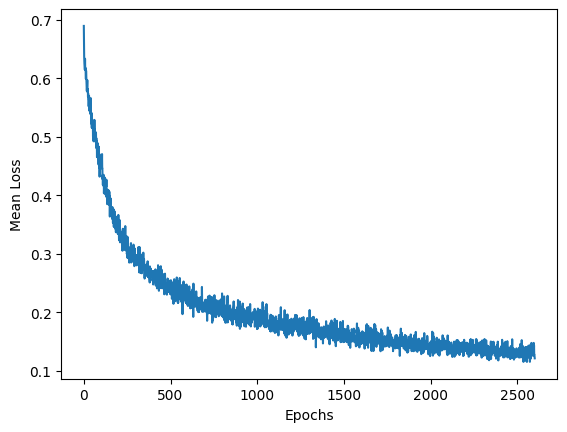

Epoch: 2600, Loss: 0.12095004320144653


 52%|█████▎    | 2625/5000 [5:43:11<1:36:27,  2.44s/it]

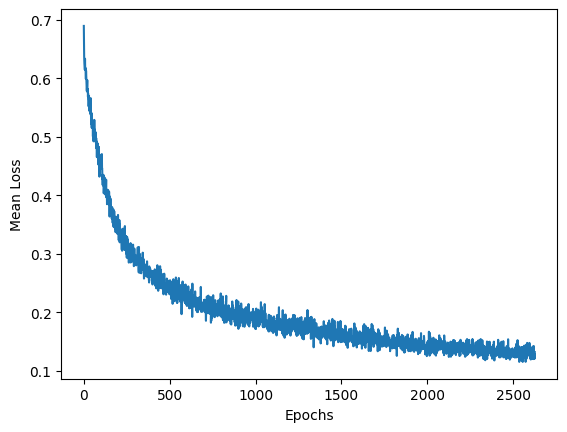

Epoch: 2625, Loss: 0.13180403411388397


 53%|█████▎    | 2650/5000 [6:10:04<33:08:40, 50.77s/it]  

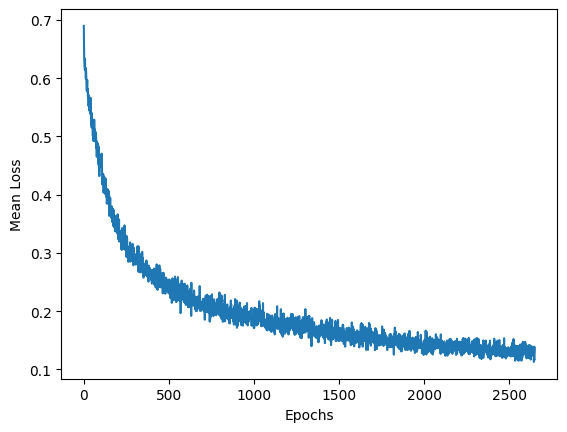

Epoch: 2650, Loss: 0.11694600433111191


 54%|█████▎    | 2675/5000 [6:14:03<4:03:46,  6.29s/it] 

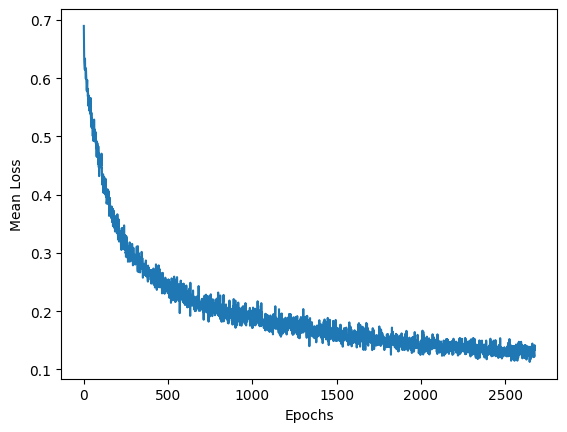

Epoch: 2675, Loss: 0.1336425393819809


 54%|█████▍    | 2700/5000 [6:22:36<7:53:08, 12.34s/it] 

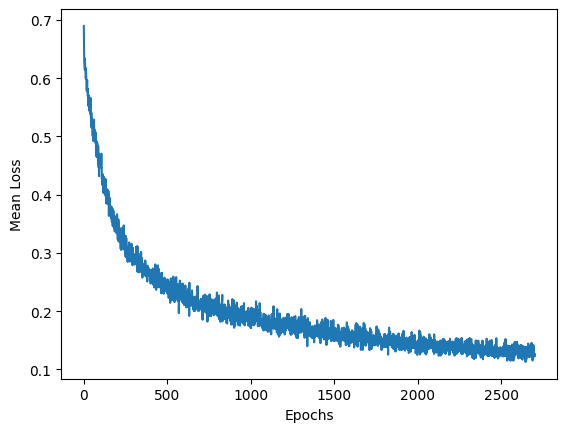

Epoch: 2700, Loss: 0.12627705931663513


 55%|█████▍    | 2725/5000 [6:59:06<7:47:17, 12.32s/it]   

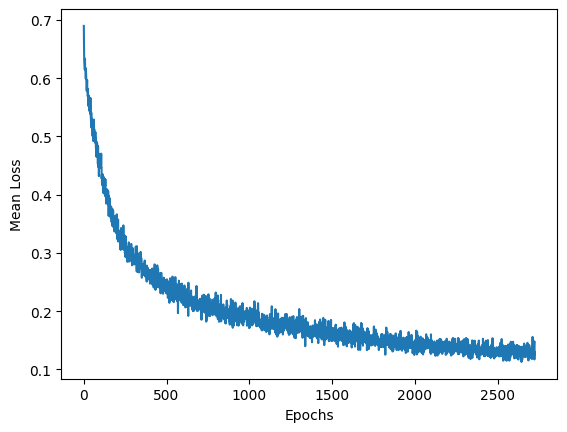

Epoch: 2725, Loss: 0.1468515694141388


 55%|█████▌    | 2750/5000 [7:00:04<1:22:24,  2.20s/it]

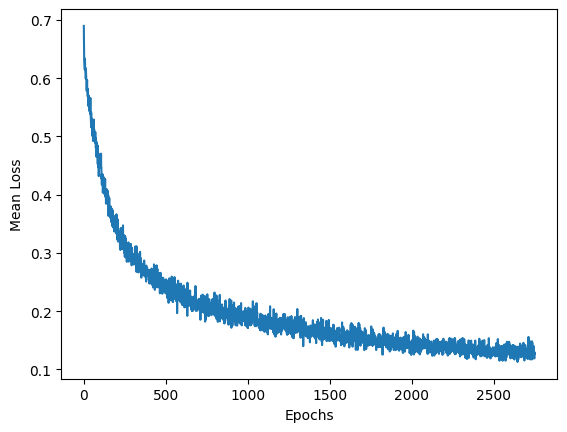

Epoch: 2750, Loss: 0.12683524191379547


 56%|█████▌    | 2775/5000 [7:01:06<1:36:59,  2.62s/it]

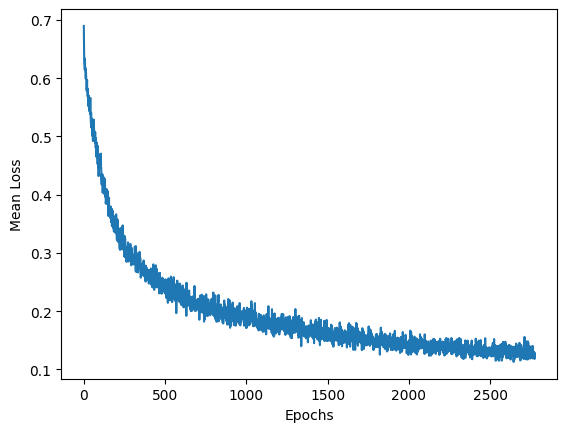

Epoch: 2775, Loss: 0.11966343969106674


 56%|█████▌    | 2800/5000 [7:02:04<1:22:39,  2.25s/it]

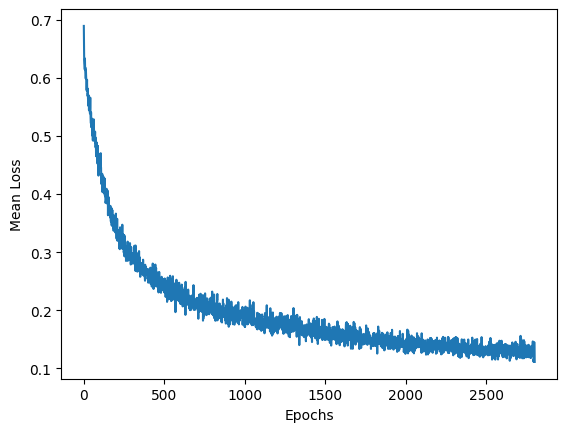

Epoch: 2800, Loss: 0.11082862317562103


 56%|█████▋    | 2825/5000 [7:03:02<1:27:27,  2.41s/it]

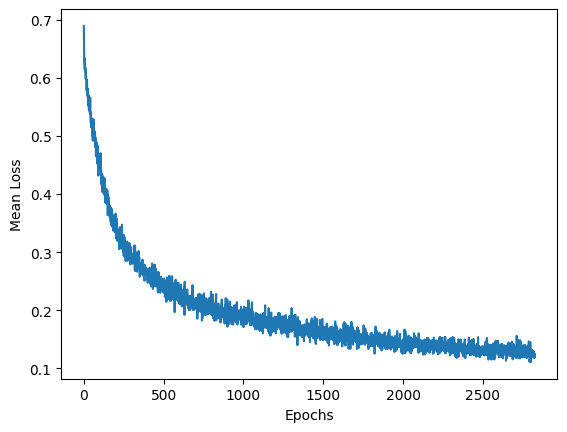

Epoch: 2825, Loss: 0.11935071647167206


 57%|█████▋    | 2850/5000 [7:04:00<1:26:59,  2.43s/it]

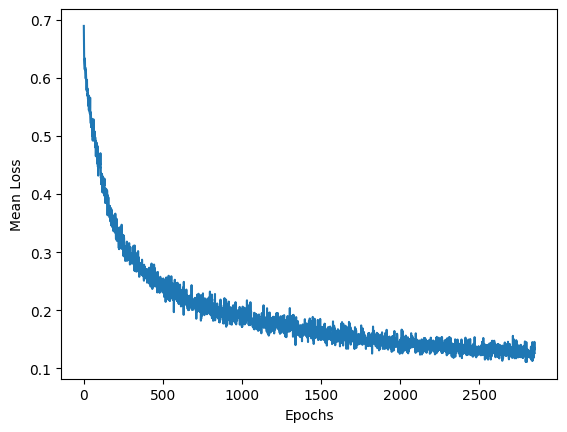

Epoch: 2850, Loss: 0.12615543603897095


 57%|█████▊    | 2875/5000 [7:05:00<1:26:12,  2.43s/it]

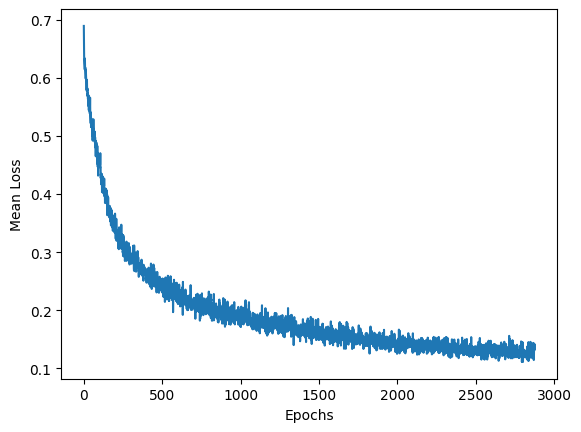

Epoch: 2875, Loss: 0.13960890471935272


 58%|█████▊    | 2900/5000 [7:05:59<1:20:31,  2.30s/it]

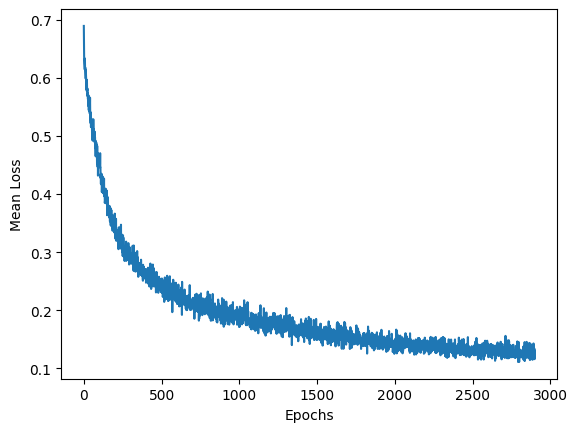

Epoch: 2900, Loss: 0.13016735017299652


 58%|█████▊    | 2925/5000 [7:06:58<1:23:50,  2.42s/it]

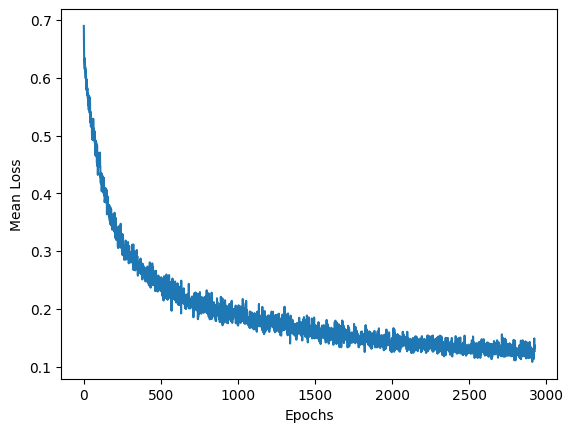

Epoch: 2925, Loss: 0.1269810050725937


 59%|█████▉    | 2950/5000 [7:08:00<1:25:55,  2.51s/it]

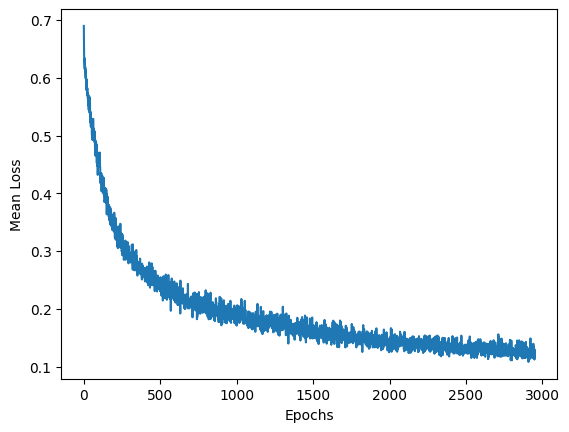

Epoch: 2950, Loss: 0.11694961786270142


 60%|█████▉    | 2975/5000 [7:08:59<1:19:50,  2.37s/it]

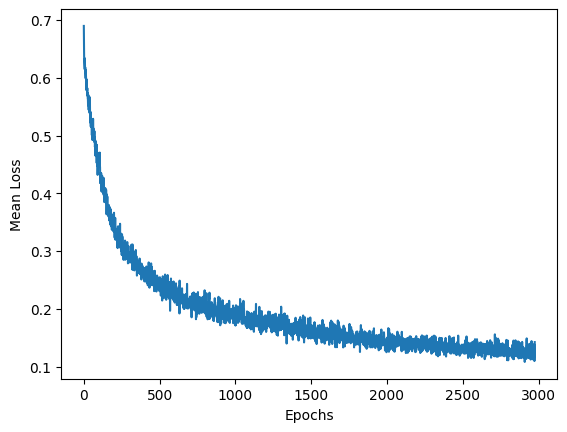

Epoch: 2975, Loss: 0.14232568442821503


 60%|██████    | 3000/5000 [7:10:01<1:22:04,  2.46s/it]

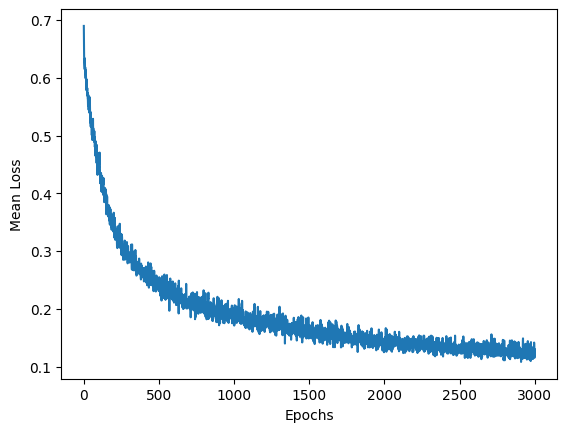

Epoch: 3000, Loss: 0.11928188800811768


 60%|██████    | 3025/5000 [7:11:01<1:21:02,  2.46s/it]

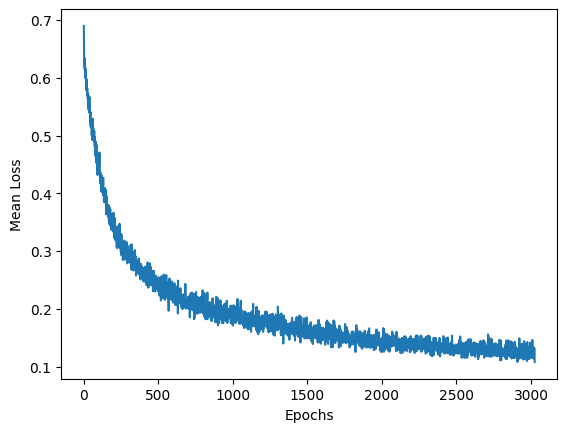

Epoch: 3025, Loss: 0.10798437893390656


 61%|██████    | 3050/5000 [7:11:59<1:16:47,  2.36s/it]

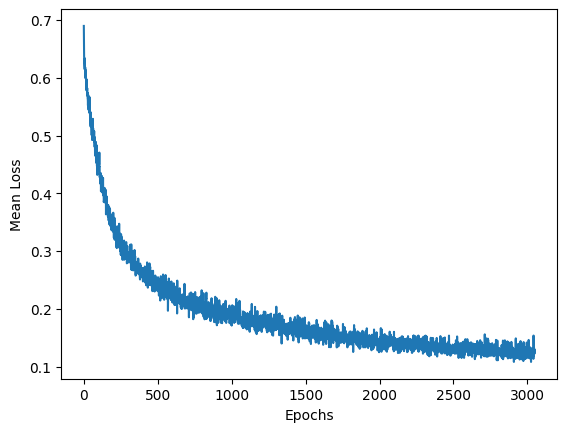

Epoch: 3050, Loss: 0.1282918006181717


 62%|██████▏   | 3075/5000 [7:12:58<1:15:43,  2.36s/it]

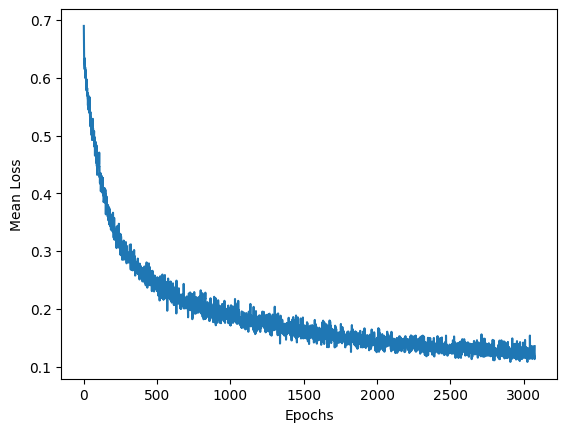

Epoch: 3075, Loss: 0.1352188140153885


 62%|██████▏   | 3100/5000 [7:13:57<1:14:30,  2.35s/it]

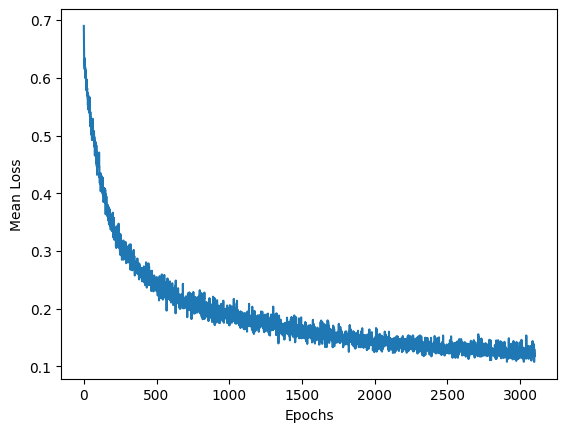

Epoch: 3100, Loss: 0.1178787499666214


 62%|██████▎   | 3125/5000 [7:14:57<1:16:54,  2.46s/it]

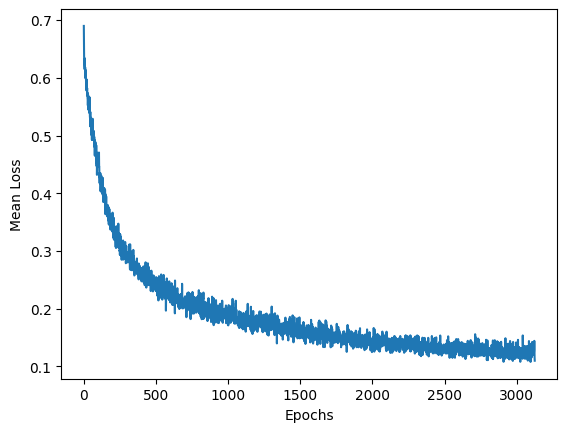

Epoch: 3125, Loss: 0.10985718667507172


 63%|██████▎   | 3150/5000 [7:15:57<1:15:33,  2.45s/it]

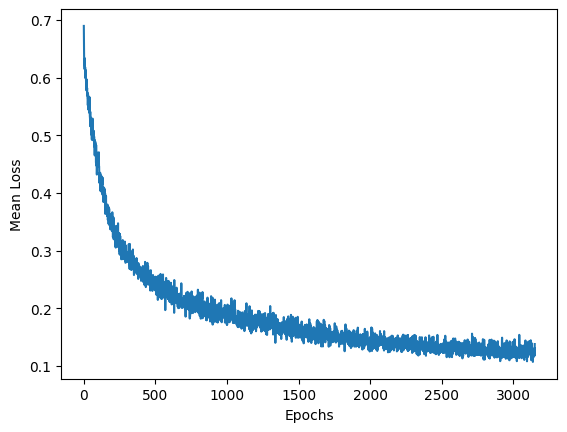

Epoch: 3150, Loss: 0.13770301640033722


 64%|██████▎   | 3175/5000 [7:16:59<1:18:32,  2.58s/it]

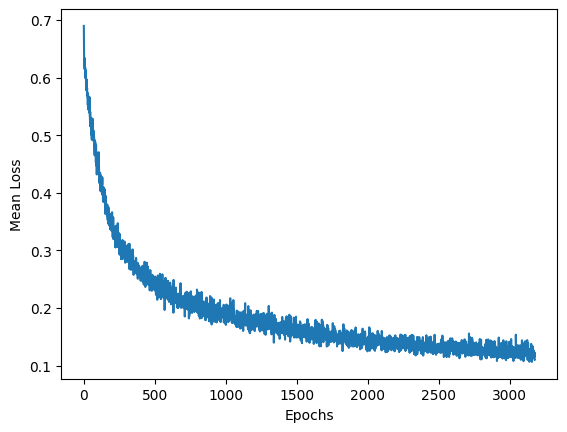

Epoch: 3175, Loss: 0.10999710857868195


 64%|██████▍   | 3200/5000 [7:18:00<1:11:53,  2.40s/it]

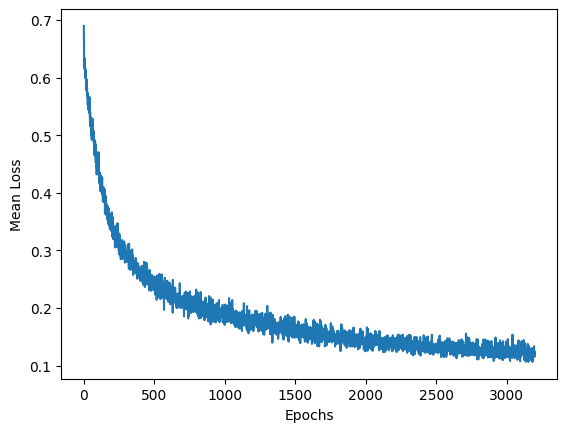

Epoch: 3200, Loss: 0.1212385892868042


 64%|██████▍   | 3225/5000 [7:19:02<1:14:21,  2.51s/it]

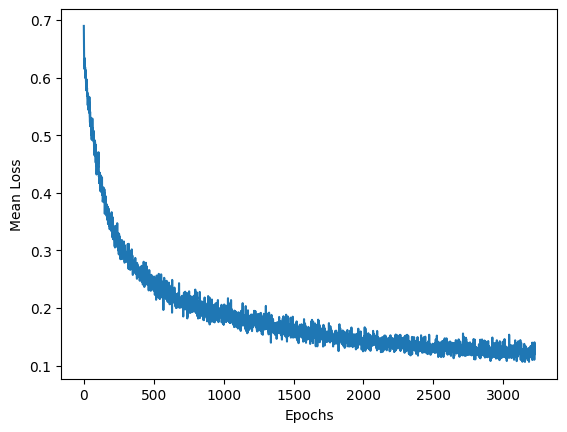

Epoch: 3225, Loss: 0.12004388868808746


 65%|██████▌   | 3250/5000 [7:20:03<1:11:13,  2.44s/it]

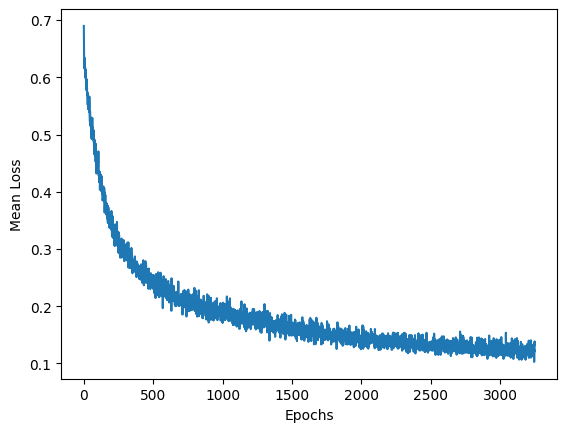

Epoch: 3250, Loss: 0.13274838030338287


 66%|██████▌   | 3275/5000 [7:21:04<1:11:53,  2.50s/it]

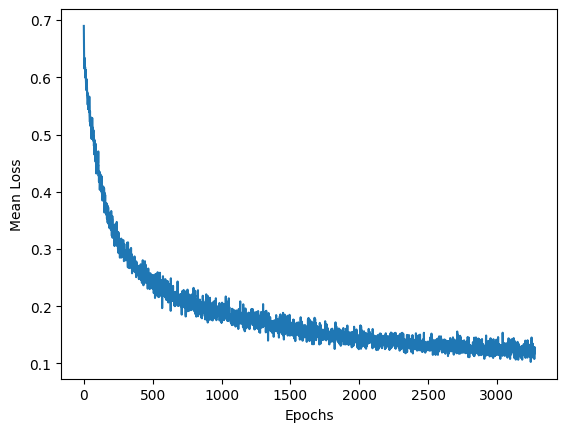

Epoch: 3275, Loss: 0.11789368093013763


 66%|██████▌   | 3300/5000 [7:22:03<1:07:51,  2.39s/it]

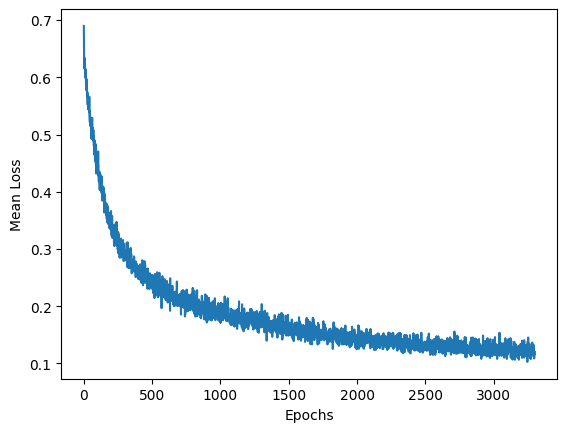

Epoch: 3300, Loss: 0.1199575886130333


 66%|██████▋   | 3325/5000 [7:23:02<1:04:01,  2.29s/it]

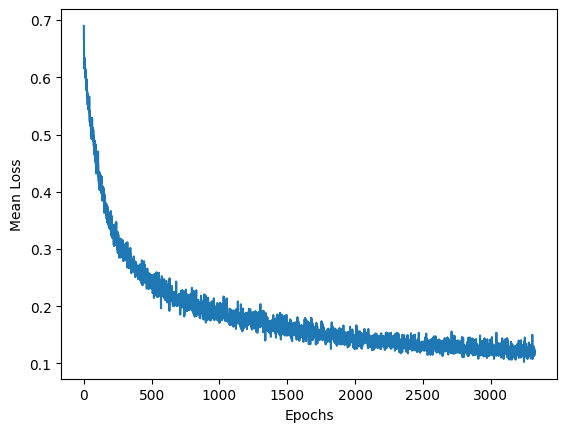

Epoch: 3325, Loss: 0.11822245270013809


 67%|██████▋   | 3350/5000 [7:24:01<1:06:59,  2.44s/it]

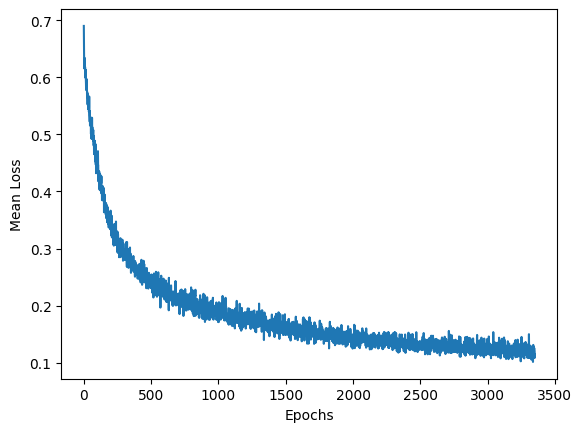

Epoch: 3350, Loss: 0.11523588001728058


 68%|██████▊   | 3375/5000 [7:25:00<1:04:44,  2.39s/it]

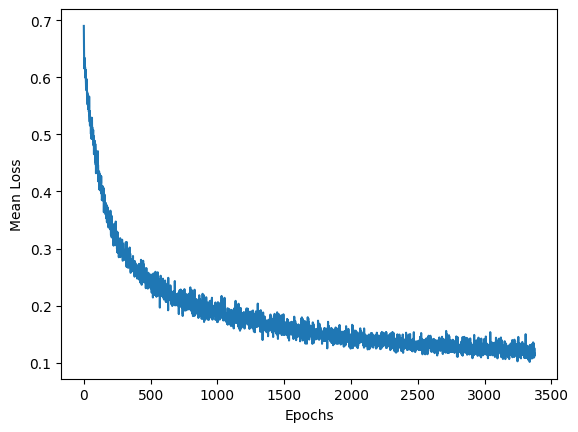

Epoch: 3375, Loss: 0.1156330555677414


 68%|██████▊   | 3400/5000 [7:26:00<1:02:13,  2.33s/it]

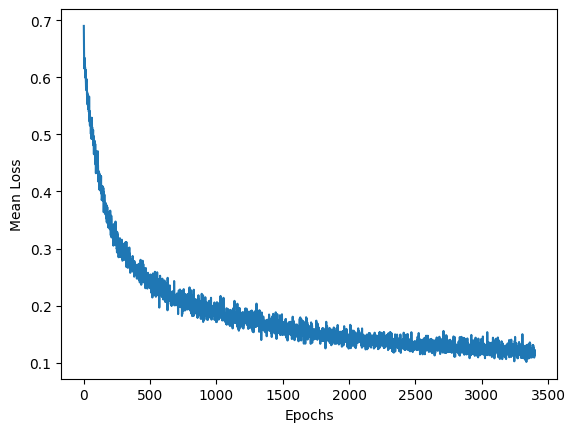

Epoch: 3400, Loss: 0.12020832300186157


 68%|██████▊   | 3425/5000 [7:26:59<1:01:32,  2.34s/it]

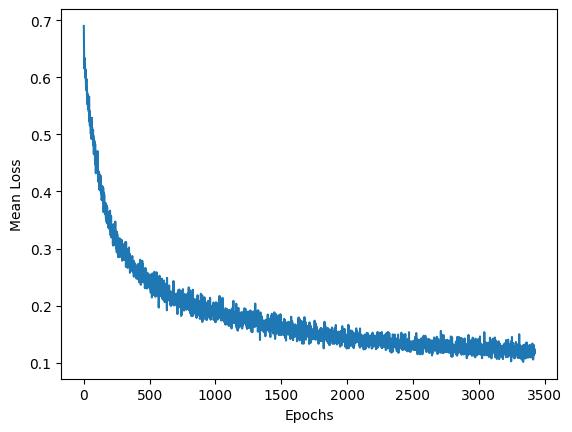

Epoch: 3425, Loss: 0.12319505214691162


 69%|██████▉   | 3450/5000 [7:27:57<59:06,  2.29s/it]  

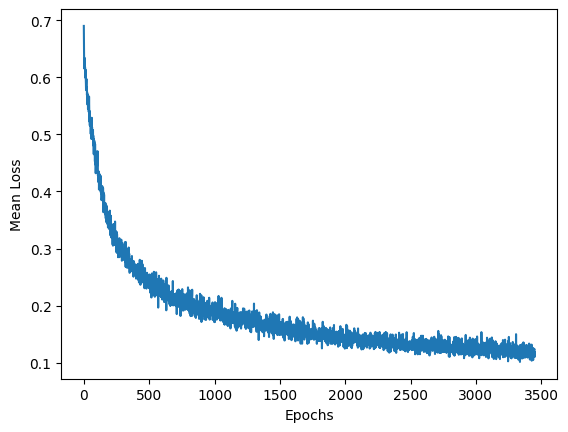

Epoch: 3450, Loss: 0.11813703924417496


 70%|██████▉   | 3475/5000 [7:28:54<58:57,  2.32s/it]  

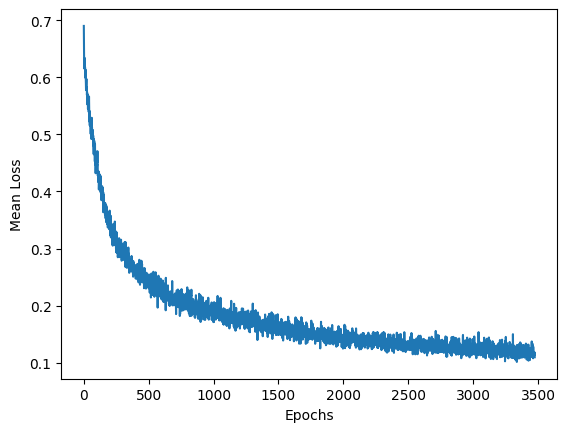

Epoch: 3475, Loss: 0.10971850156784058


 70%|███████   | 3500/5000 [7:29:54<58:42,  2.35s/it]  

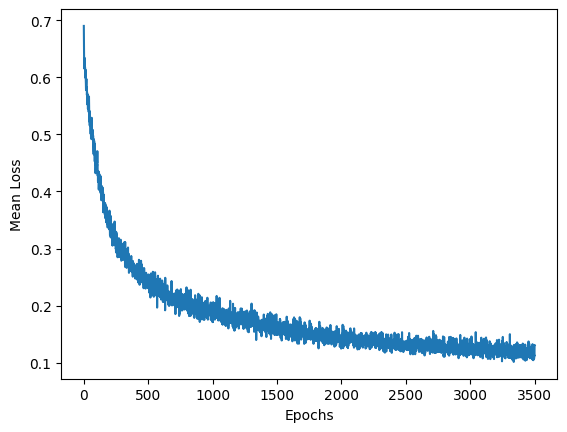

Epoch: 3500, Loss: 0.1308392584323883


 70%|███████   | 3525/5000 [7:30:52<53:56,  2.19s/it]  

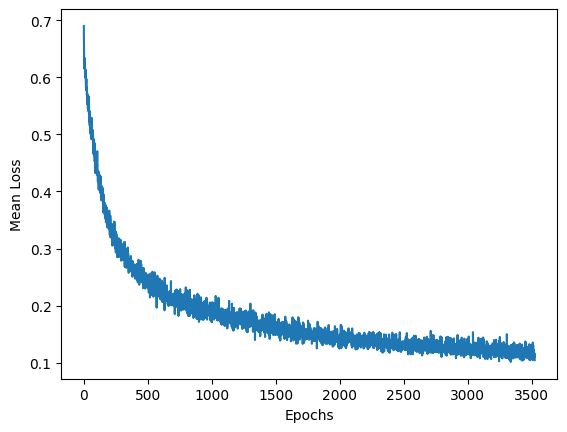

Epoch: 3525, Loss: 0.1045951396226883


 71%|███████   | 3550/5000 [7:31:47<53:51,  2.23s/it]

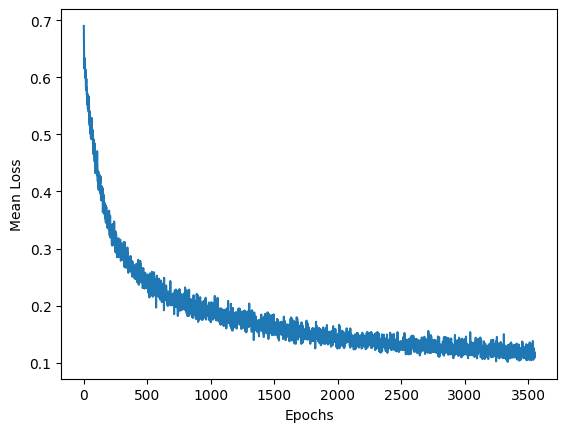

Epoch: 3550, Loss: 0.10951808840036392


 72%|███████▏  | 3575/5000 [7:32:43<51:25,  2.16s/it]  

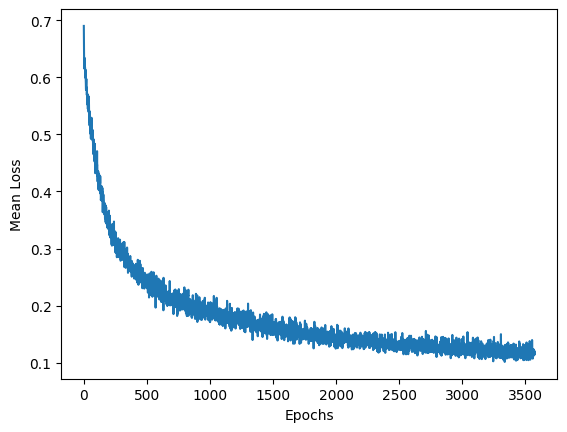

Epoch: 3575, Loss: 0.11816078424453735


 72%|███████▏  | 3600/5000 [7:33:40<54:01,  2.32s/it]

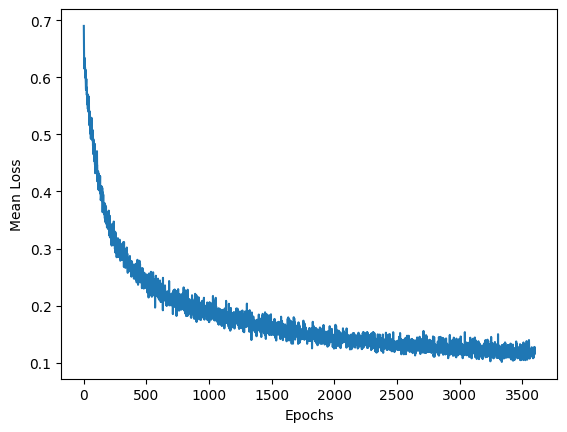

Epoch: 3600, Loss: 0.11652450263500214


 72%|███████▎  | 3625/5000 [7:34:39<53:29,  2.33s/it]

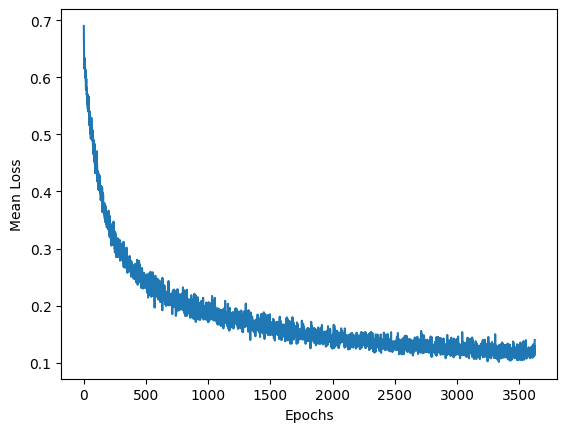

Epoch: 3625, Loss: 0.13980242609977722


 73%|███████▎  | 3650/5000 [7:35:39<55:48,  2.48s/it]

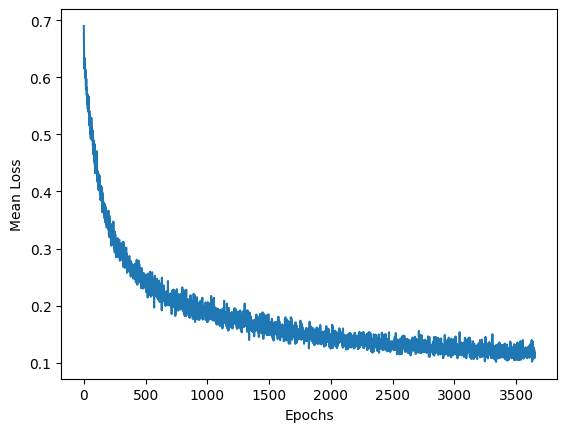

Epoch: 3650, Loss: 0.11658425629138947


 74%|███████▎  | 3675/5000 [7:36:38<50:53,  2.30s/it]

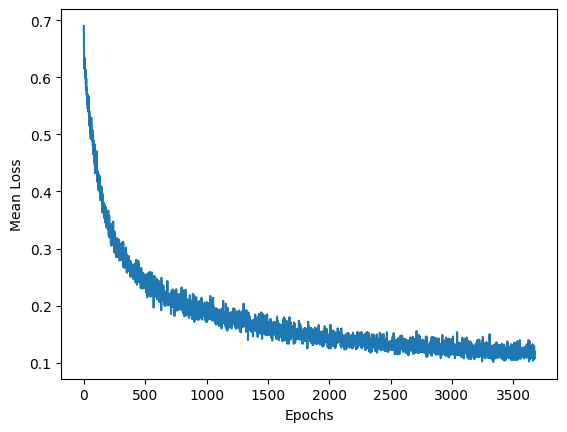

Epoch: 3675, Loss: 0.11038877815008163


 74%|███████▍  | 3700/5000 [7:37:37<51:17,  2.37s/it]

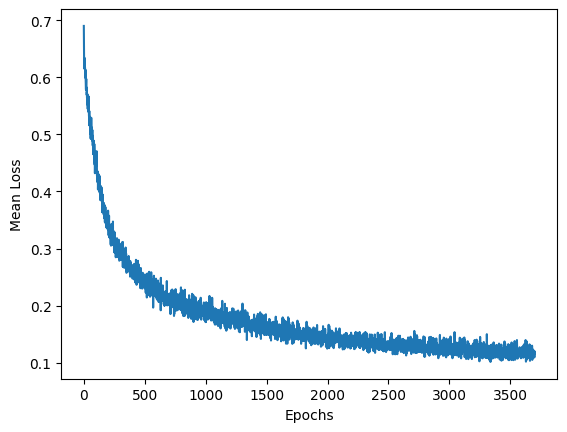

Epoch: 3700, Loss: 0.11657202243804932


 74%|███████▍  | 3725/5000 [7:38:38<52:26,  2.47s/it]

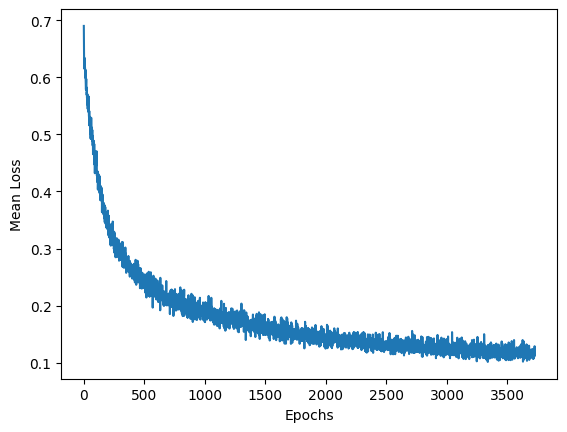

Epoch: 3725, Loss: 0.11398208141326904


 75%|███████▌  | 3750/5000 [7:39:38<51:21,  2.47s/it]

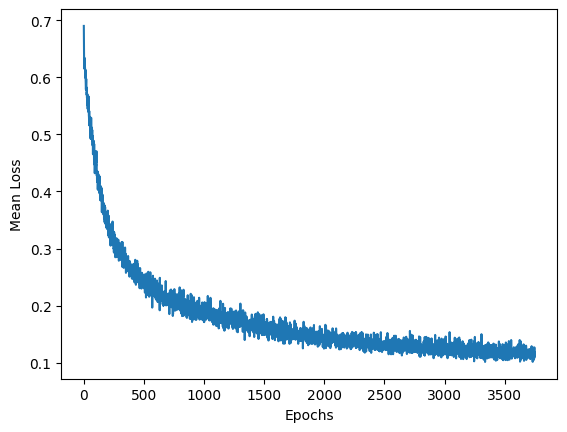

Epoch: 3750, Loss: 0.11794136464595795


 76%|███████▌  | 3775/5000 [7:40:37<48:23,  2.37s/it]

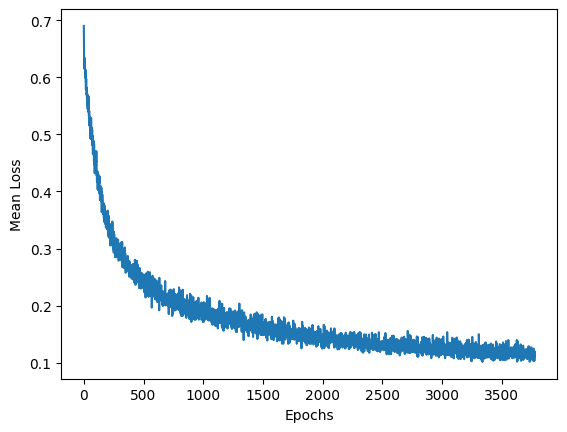

Epoch: 3775, Loss: 0.10514043271541595


 76%|███████▌  | 3787/5000 [7:41:11<2:27:43,  7.31s/it]


KeyboardInterrupt: 

In [11]:
model.train(X, y, task_lengths, 5000)

In [ ]:
test = pd.DataFrame()
for name in os.listdir("../datasets/mw_valid"):
    if not (name.startswith('.')):
        dir_name = 'mw_valid/'+name
        print(dir_name)
        df = read_file(dir_name)
        test = pd.concat([data, df])

test.reset_index(drop=True, inplace=True)
Test = PreferenceMAML(test, input_size, hidden_size1, hidden_size2, output_size)
test_X, test_y = Test.prepare_data(k=4)


# Evaluate the model on the test set
def evaluate_model(model, X, y):
    predictions = []
    with torch.no_grad():
        for i in range(len(X)):
            X_tensor = torch.tensor(X[i], dtype=torch.float32)
            output = model.model(X_tensor.unsqueeze(0))  
            predictions.append(output.squeeze().numpy())  

    preds = []
    for _ in range(len(predictions)):
        preds.append((np.array(predictions[_]).mean()))

    pred_label = []
    for i in range(len(preds)):
        pred_label.append([0] if preds[i]>0.5 else [1])
    
    sum = 0
    for _ in range(len(y)):
        sum += pred_label[_]==y[_]
    accuracy = sum/len(y)
    return accuracy, pred_label

test_accuracy, pred_labels = evaluate_model(model, test_X, test_y)
print(f'\nTest Accuracy: {test_accuracy}')

### Without INNER LOOP

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes



#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]


#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):

#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis = 1))
#                 y.append([self.compare_probabilities(sigma1, sigma2)]) 

#         return X, y


#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in range(len(X)):
#             loss = self._compute_loss(X[i], y[i])
#             outer_losses.append(loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _compute_loss(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor([y], dtype=torch.float32)
#         output = self.model(X_tensor)
#         output_flat = output.view(-1)
#         y_flat = y_tensor.view(-1)
#         loss = self.reward_criterion(output_flat[-2:], y_flat)
#         return loss

# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 20

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": 0.005})

# X, y = model.prepare_data(k=4)

# # Train the model
# for epoch in range(num_epochs):
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


### With INNER LOOP but Improper classification

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         inner_lr = 0.01,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps
#         self.inner_lr = inner_lr

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes

#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]

#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):
#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
#                 y.append(self.compare_probabilities(sigma1, sigma2))

#         return X, y

#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in tqdm(range(len(X))):
#             if len(X[i])>self.num_support:
#                 support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
#                 # Inner loop (adaptation)
#                 adapted_model = self._inner_loop(support_X, support_y)
#                 # Compute loss using the adapted model on query set
#                 query_loss = self._compute_loss(adapted_model, query_X, query_y)
#                 outer_losses.append(query_loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _inner_loop(self, support_X, support_y):
#         adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
#                               self.model.fc2.out_features, self.model.fc3.out_features)
#         adapted_model.load_state_dict(self.model.state_dict())

#         inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

#         for _ in range(self.num_inner_steps):
#             inner_optimizer.zero_grad()
#             loss = self._compute_loss(adapted_model, support_X, support_y)
#             print(loss)
#             loss.backward()
#             inner_optimizer.step()

#         return adapted_model

#     def _compute_loss(self, model, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_class = [0 if y[i]==[1,0] else 1 for i in range(len(y))]
#         y_tensor = torch.tensor(y_class, dtype=torch.long)  # Assuming y is class indices
#         output = model(X_tensor)

#         loss = self.reward_criterion(output, y_tensor)
#         return loss

#     def _split_support_query(self, X, y):
#         num_samples = len(X)
#         all_indices = np.arange(num_samples)
#         # Randomly sample support indices
#         support_indices = np.random.choice(num_samples, self.num_support, replace=False)
#         query_indices = np.setdiff1d(all_indices, support_indices)
#         support_X = X[support_indices]
#         query_X = X[query_indices]
#         # For y, we can simply use the same indices as for X, as it has a fixed length of 2
#         support_y = [y] * self.num_support
#         query_y = [y] * len(query_indices)

#         return support_X, support_y, query_X, query_y


# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 5
# outer_lr = 0.001

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

# print('Preparing Data.')
# # X, y = model.prepare_data(k=4)
# print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")
